In [2]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import random
import json
import os
import re
import seaborn as sns
import math

## Plot Origin FSD

In [3]:
def draw_flow_size_distribution(fileNames):
    
    fs = []
    prob = []
    cdfs = []
    labels = []
    
    for fileName in fileNames: 
        print(fileName)
        flow_size = []
        frequency = []
        total_packets = 0
    
        with open(fileName, "r") as file:
            for line in file:
                items = line.strip().split(" ")
                flow_size.append(int(items[0]))
                frequency.append(int(items[1]))
                total_packets += int(items[0])*int(items[1])
            
            
        # Calculate mean and variance
        flow_sizes_array = np.array(flow_size)
        frequencies_array = np.array(frequency)

        mean_flow_size = np.average(flow_sizes_array, weights=frequencies_array)
        variance_flow_size = np.average((flow_sizes_array - mean_flow_size)**2, weights=frequencies_array)
    
        # print("Mean Flow Size:", mean_flow_size)
        # print("Variance of Flow Size:", variance_flow_size)
        
        # Plot PDF & CDF
        total_flows = sum(frequency)
        probabilities = [freq / total_flows for freq in frequency]
        # print(flow_size)
        print("Total Flows: ", total_flows)
        print("Total Packets: ", total_packets)
        print("Density: ", int(total_packets/total_flows))
        # print(probabilities)
        
        cdf = np.cumsum(probabilities)
        
        fs.append(flow_size)
        prob.append(probabilities)
        cdfs.append(cdf)
        labels.append(fileName.split("/")[-1][:-4])
    
    plt.figure(figsize=(10, 5))
    # Plot PDF
    plt.subplot(1, 2, 1)
    
    for i in range(len(fs)):
        plt.plot(fs[i], prob[i], linestyle='-', label = labels[i])
    
    # plt.bar(flow_size, probabilities, width=1.0, color='blue', alpha=0.7)
    plt.title('Probability Density Function (PDF)')
    plt.xlabel('Flow Size')
    plt.ylabel('Probability')
    plt.legend(loc="upper right")
    
    plt.xscale('log')  # Set x-axis scale to logarithmic
    plt.xlim([-10,10000])
    plt.xticks([1, 10, 100, 1000, 10000, 100000, 1000000])  # Set specific tick positions
    plt.grid(True)
    
    # Plot CDF
    plt.subplot(1, 2, 2)
    for i in range(len(fs)):
        plt.plot(fs[i], cdfs[i], linestyle='-', label = labels[i])
    plt.title('Cumulative Distribution Function (CDF)')
    plt.xlabel('Flow Size')
    plt.ylabel('Cumulative Probability')
    plt.legend(loc="lower right")
    
    plt.xscale('log')  # Set x-axis scale to logarithmic
    plt.xlim([-10,100000])
    plt.xticks([1, 10, 100, 1000, 10000, 100000, 1000000])  # Set specific tick positions

    plt.grid(True)
    
    
    plt.tight_layout()
    plt.show()
    
# draw_flow_size_distribution("/home/ming/SketchMercator/traffic_sampler/fs_dist/fs_dist.txt")

/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0517-125w.txt
Total Flows:  26938
Total Packets:  1254001
Density:  46
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0517-250w.txt
Total Flows:  53878
Total Packets:  2441598
Density:  45
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0517-500w.txt
Total Flows:  107755
Total Packets:  5061345
Density:  46
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0816-150w.txt
Total Flows:  28343
Total Packets:  1519854
Density:  53
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0816-300w.txt
Total Flows:  56686
Total Packets:  2933291
Density:  51
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0816-600w.txt
Total Flows:  113373
Total Packets:  5857213
Density:  51
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/zipf2a-150w.txt
Total Flows:  77378
Total Packets:  

/tmp/ipykernel_16691/3322723123.py:62: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([-10,10000])
/tmp/ipykernel_16691/3322723123.py:76: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([-10,100000])


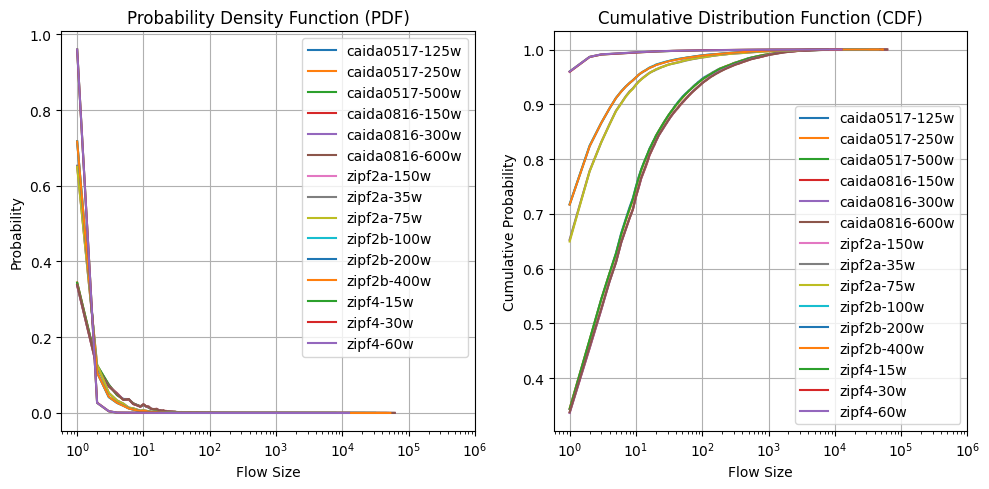

/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0517-125w.txt
Total Flows:  26938
Total Packets:  1254001
Density:  46
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0517-250w.txt
Total Flows:  53878
Total Packets:  2441598
Density:  45
/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/caida0517-500w.txt
Total Flows:  107755
Total Packets:  5061345
Density:  46


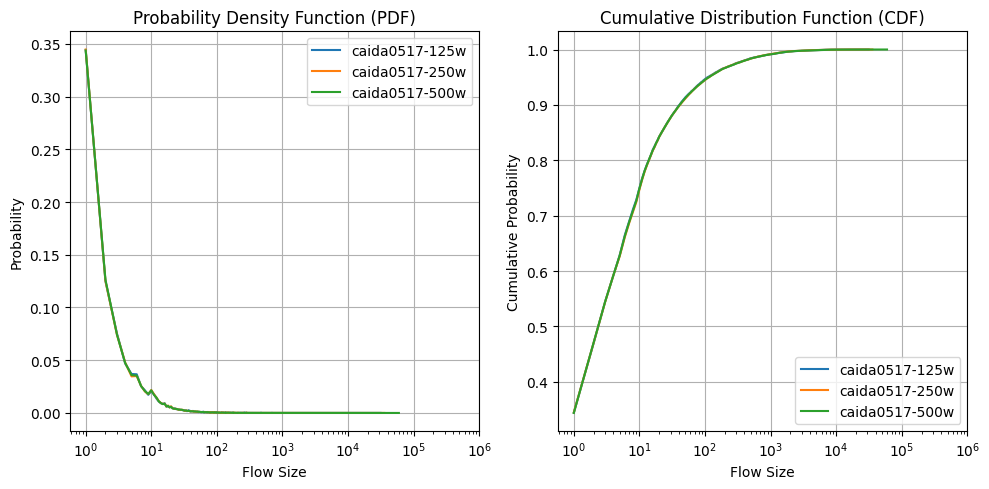

In [4]:
pcap_folder = "/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/"
pcap_file = []
for file_name in sorted(os.listdir(pcap_folder)):
    file_path = pcap_folder + file_name
    pcap_file.append(file_path)
    
# for file in pcap_file:
#     draw_flow_size_distribution(file)
#     break

draw_flow_size_distribution(pcap_file)
# draw_flow_size_distribution(pcap_file[::3])
draw_flow_size_distribution(pcap_file[:3])
# draw_flow_size_distribution(pcap_file[3:6])
# draw_flow_size_distribution(pcap_file[6:9])
# draw_flow_size_distribution(pcap_file[9:12])
# draw_flow_size_distribution(pcap_file[12:15])


## Prepare dataset

In [5]:
def read_fsd_data(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['10'], dataset='caida0517-125w_10_.pcap', window_size=200):
    res = []
    for epoch in epochs:
        
        path = f"../SketchPatternQuery/{algo}/{dataset}/"\
                f"{flowkey}/row_{row}_width_{width}_level_{level}_epoch_{epoch}_count_{count}_seed_{seed}/"
        
        for dir in sorted(os.listdir(path)):
            p = os.path.join(path, dir)
            if os.path.isdir(p): 
                window_dir = "window_" + str(window_size)
                dynamic_full_path = os.path.join(path, dir, window_dir, "randk_summation")
                
                for file in sorted(os.listdir(dynamic_full_path)):  
                    fsd_file = os.path.join(dynamic_full_path, file)
                    fsd = {}
                    with open(fsd_file, 'r') as f:
                        for line in f:
                            fsd[int(line.strip().split()[0])] = int(line.strip().split()[1])
                            
                    res.append(fsd)
            
    return res

# read_fsd_data()

In [24]:
## parameters

caida0517 = ["caida0517-500w", "caida0517-250w", "caida0517-125w"]
caida0816 = ["caida0816-600w", "caida0816-300w", "caida0816-150w"]
zipf2a = ["zipf2a-150w", "zipf2a-75w", "zipf2a-35w"]
zipf2b = ["zipf2b-400w", "zipf2b-200w", "zipf2b-100w"]
zipf4 = ["zipf4-60w", "zipf4-30w", "zipf4-15w"]


lens = [
        # ["5", "5"],
        ["6", "4"],
        # ["7", "3"],
        # ["8", "2"],
        ]

pcap_file = []
    
# # single dataset
pcap_file.append("caida0517-500w_10_.pcap")
pcap_file.append("caida0517-250w_10_.pcap")
pcap_file.append("caida0517-125w_10_.pcap")
pcap_file.append("caida0816-600w_10_.pcap")
pcap_file.append("caida0816-300w_10_.pcap")
pcap_file.append("caida0816-150w_10_.pcap")
pcap_file.append("zipf2a-150w_10_.pcap") 
pcap_file.append("zipf2a-75w_10_.pcap") 
pcap_file.append("zipf2a-35w_10_.pcap") 
pcap_file.append("zipf2b-400w_10_.pcap") 
pcap_file.append("zipf2b-200w_10_.pcap") 
pcap_file.append("zipf2b-100w_10_.pcap") 

# pcap_file.append("zipf4-60w_10_.pcap")
# pcap_file.append("zipf4-30w_10_.pcap")
# pcap_file.append("zipf4-15w_10_.pcap")


# # # same dist, caida
# for a in caida0517:
#     for b in caida0816:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in caida0816:
#     for b in caida0517:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
# # # same dist, zipf
# for a in zipf2a:
#     for b in zipf2b:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in zipf2b:
#     for b in zipf2a:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')

# # # diff dist, caida + zipf2a
# for a in caida0517:
#     for b in zipf2a:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in caida0816:
#     for b in zipf2a:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
# # # # diff dist, caida + zipf2b
# for a in caida0517:
#     for b in zipf2b:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in caida0816:
#     for b in zipf2b:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
# # # # diff dist, caida + zipf4
# for a in caida0517:
#     for b in zipf4:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in caida0816:
#     for b in zipf4:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')

# # # diff dist, zipf2a + caida
# for a in zipf2a:
#     for b in caida0517:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
    # for b in caida0816:
    #     for l in lens:
    #         pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
# # # diff dist, zipf2b + caida
# for a in zipf2b:
#     for b in caida0517:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
#     for b in caida0816:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
# # # diff dist, zipf4 + caida
# for a in zipf4:
#     for b in caida0517:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
#     for b in caida0816:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')

# # # # diff dist, zipf 2a + zipf4
# for a in zipf2a:
#     for b in zipf4:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in zipf4:
#     for b in zipf2a:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
# # # # diff dist, zipf 2b + zipf4
# for a in zipf2b:
#     for b in zipf4:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
# for a in zipf4:
#     for b in zipf2b:
#         for l in lens:
#             pcap_file.append(f'{a}_{l[0]}_{b}_{l[1]}.pcap')
            
            
            
print(pcap_file)    
print(f'Total Pcap File Number: {len(pcap_file)}')
# widths = [2048, 4096, 8192, 16384, 32768, 65536, 131072]
widths = [4096]
# widths = [1024]



['caida0517-500w_10_.pcap', 'caida0517-250w_10_.pcap', 'caida0517-125w_10_.pcap', 'caida0816-600w_10_.pcap', 'caida0816-300w_10_.pcap', 'caida0816-150w_10_.pcap', 'zipf2a-150w_10_.pcap', 'zipf2a-75w_10_.pcap', 'zipf2a-35w_10_.pcap', 'zipf2b-400w_10_.pcap', 'zipf2b-200w_10_.pcap', 'zipf2b-100w_10_.pcap']
Total Pcap File Number: 12


### Plot Density Variation

In [7]:
def plot_density_variation(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['10'], dataset='caida0517-125w_10_.pcap', window_size=200):

    labels = ["Random K Density"]

    res = []
    # sum
    result = read_fsd_data(algo, row, width, level, seed, count, flowkey, epochs, dataset, window_size)
    
    acc_fs = []
    for fsd in result:
        tfs = 0
        fn = 0
        for size, freq in fsd.items():
            fn += freq
            tfs += (size*freq)
        
        # print(fn, tfs)
            
        acc_fs.append(int(tfs))
    
    print(acc_fs)
        
    # variation
    var_fs = [None]
    var_fs.append(int(round(acc_fs[0]/1000)))
    for i in range(1, len(acc_fs)):
        # print(acc_fs[i], acc_fs[i-1], (acc_fs[i] - acc_fs[i-1]))
        var_fs.append(int(round((acc_fs[i] - acc_fs[i-1])/1000)))
    
    res.append(var_fs)
    print(sum(var_fs[1:])/len(var_fs[1:]))
    # print(labels, len(labels))
    # print(res, len(res))
    # print(result)
    
    plt.figure(figsize=(12, 4))
    
    # sns.lineplot(data=res, dashes=False, markers=True, markersize=4)
    # for i, data_set in enumerate(res):
    #     plt.plot(range(1,21), data_set, label=f'Data Set {i + 1}')
        
    # print(dataset)
    for i in range(len(res)):
        plt.plot(res[i], label=labels[i])
        

    # Add labels and legend
    plt.xlabel('Time (sec)')
    plt.ylabel('Ratio')
    plt.title('%s Random K Density (Window Size = %d)' % (dataset[:-5], window_size))
    # plt.axhline(10000, c="black")
    ticks = [i for i in range(int(10*1000/window_size) + 1)]
    adjusted_ticks = [tick * (window_size / 1000) for tick in ticks[0::int(1000 / window_size)]]
    plt.xticks(ticks[0::int(1000/window_size)], adjusted_ticks)
    plt.legend(loc='upper left', ncol=math.ceil(len(res)/4))

    # Show the plot
    plt.show()
    

[137998, 223601, 290580, 353845, 447410, 537854, 623005, 678892, 755846, 857664, 959095, 1007204, 1096445, 1211011, 1264947, 1338557, 1424954, 1490640, 1598289, 1701736, 1791085, 1878699, 1935244, 2010842, 2114530, 2209591, 2324656, 2385899, 2456298, 2544701, 2610718, 2658612, 2783423, 2806659, 2978589, 3008121, 2998016, 3172852, 3289886, 3385980, 3393998, 3494286, 3661263, 3700382, 3795894, 3814223, 3964646, 3946651]
82.22916666666667


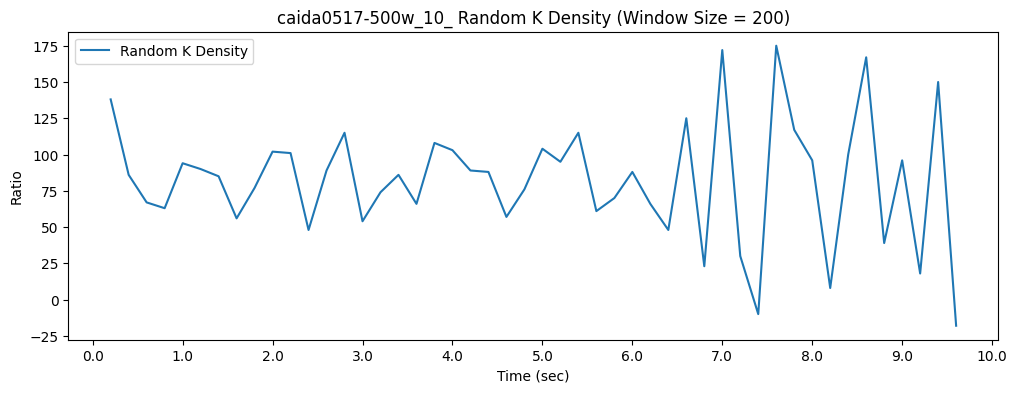

[67140, 145864, 171463, 216059, 260845, 267938, 321980, 374997, 390197, 419445, 464598, 509987, 521079, 559886, 589655, 655182, 708718, 712066, 761377, 787672, 807356, 871666, 853613, 876303, 962114, 955323, 1019992, 1057757, 1074268, 1065509, 1076484, 1117009, 1166769, 1242976, 1236727, 1244558, 1356760, 1320242, 1344637, 1417001, 1436799, 1495990, 1554795, 1523336, 1652220, 1601841, 1619883, 1647131]
34.354166666666664


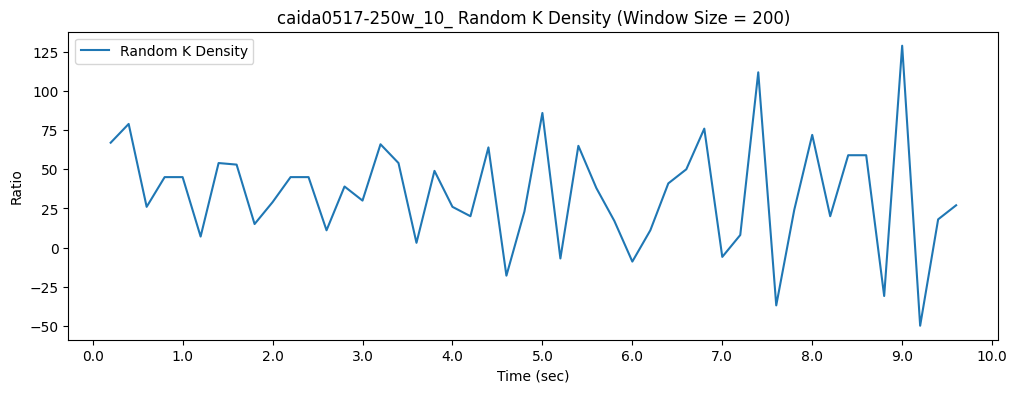

[28850, 57556, 75576, 106594, 138390, 170879, 207069, 232823, 255444, 280172, 285668, 319432, 348096, 360513, 369443, 378269, 395595, 418723, 407552, 447164, 456574, 458755, 478501, 516737, 528800, 528442, 540845, 586286, 556449, 608520, 577179, 600705, 616671, 668054, 655061, 711145, 680273, 718090, 711405, 735914, 802216, 694581, 778612, 820346, 764006, 820689, 828273, 819405]
17.083333333333332


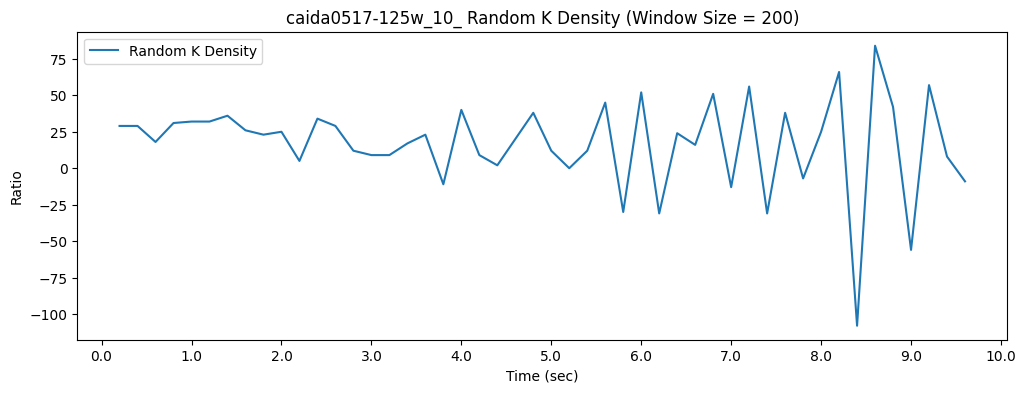

[138224, 243095, 335837, 438964, 542211, 644015, 731872, 835363, 922781, 994312, 1136467, 1220951, 1296089, 1421899, 1486654, 1577708, 1684118, 1785172, 1896409, 2009414, 2089597, 2178265, 2248473, 2348321, 2422925, 2574370, 2665441, 2743021, 2808269, 2941154, 3069374, 3173990, 3273206, 3306996, 3424750, 3528819, 3655863, 3735548, 3823465, 3940787, 3991929, 4113650, 4148239, 4246837, 4395679, 4462210, 4603624, 4703575, 4754728, 4908965]
98.18


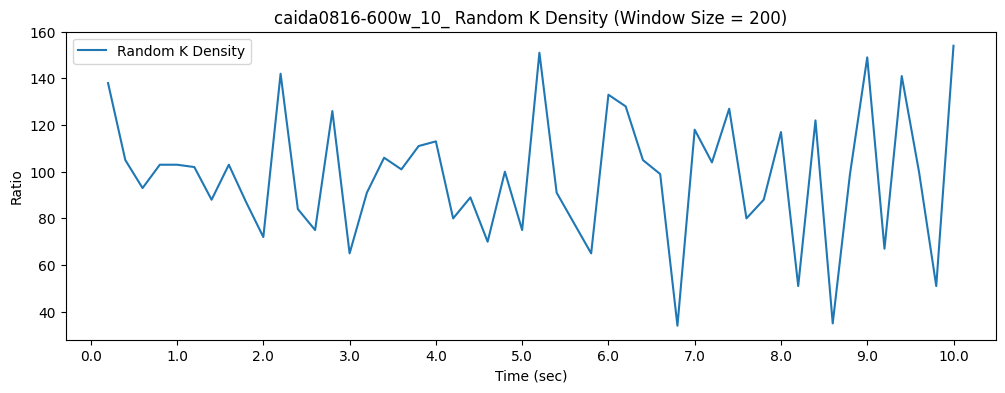

[70650, 149517, 197325, 247794, 278757, 334656, 379524, 410222, 451785, 482588, 532451, 561180, 612469, 654903, 680622, 719694, 794328, 806593, 878263, 833556, 931445, 949751, 1024358, 1019274, 1048520, 1124181, 1096428, 1162647, 1263641, 1279933, 1330241, 1324269, 1402140, 1332179, 1433785, 1481503, 1472991, 1581774, 1611877, 1617845, 1730525, 1671671, 1691793, 1797593, 1767879, 1789669, 1863282, 1905622, 1937376, 2003771]
40.1


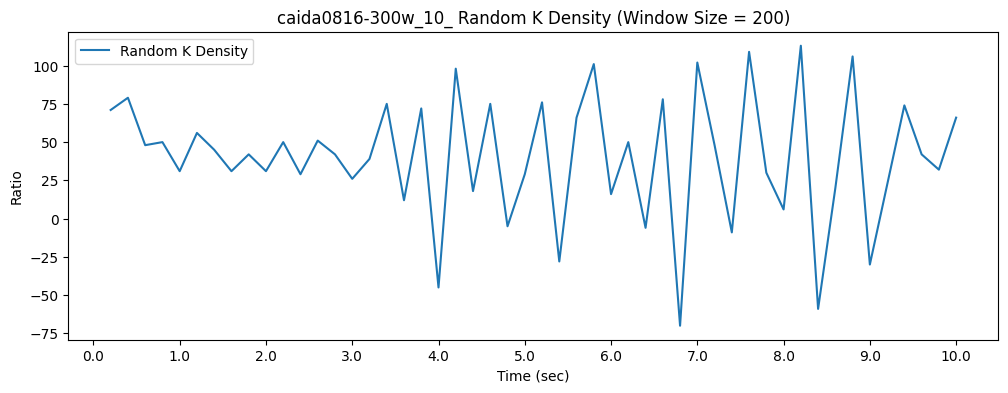

[31169, 67579, 101044, 137435, 175284, 218495, 262940, 296167, 314803, 339487, 353070, 379829, 387221, 409139, 428197, 446073, 480739, 474943, 531381, 501663, 548092, 560963, 605343, 610117, 634787, 620167, 630157, 665935, 700063, 696683, 680666, 741426, 769739, 806441, 778329, 766615, 825802, 856996, 810609, 826414, 902631, 846008, 824891, 955198, 930795, 918647, 969302, 918208, 926149, 1056235]
21.1


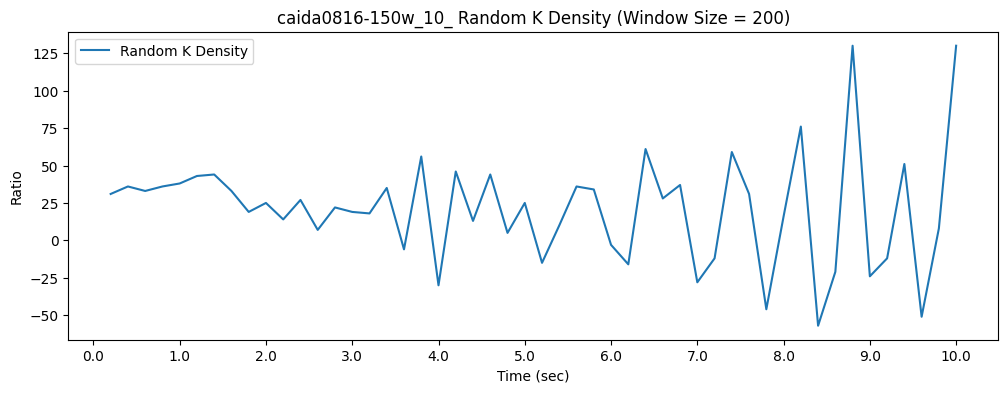

[31954, 64563, 103443, 132270, 150957, 160099, 158372, 181312, 206963, 194691, 208855, 218296, 213089, 241935, 241486, 261952, 281865, 293448, 289679, 330723, 305345, 323647, 341799, 357696, 359807, 385289, 360439, 392568, 427386, 417486, 433164, 449143, 477019, 481346, 399567, 418774, 448166, 444785, 428185, 482632, 580849, 495128, 510993, 571275, 589549, 573325, 555858, 571941, 564906, 647418]
12.94


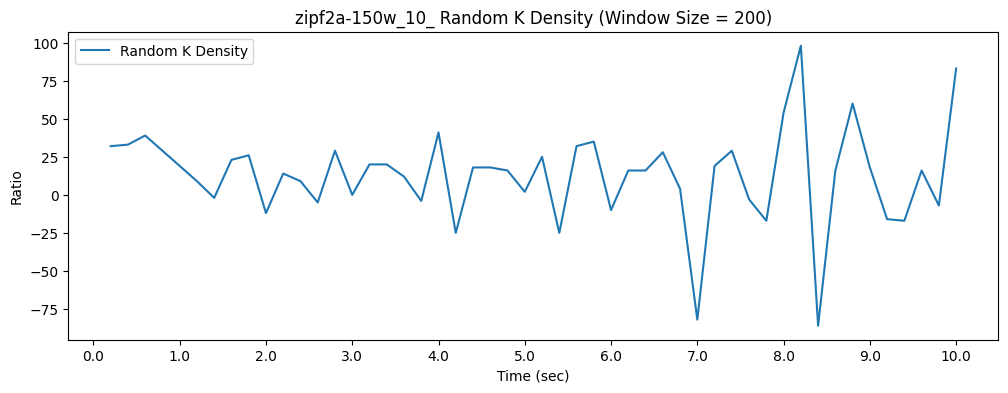

[16895, 31369, 49874, 71899, 92137, 110233, 128682, 148971, 159002, 165129, 154281, 180885, 187485, 197292, 184671, 172019, 205747, 199032, 202712, 212282, 243216, 256412, 252556, 267500, 233665, 235580, 214978, 257476, 223166, 256242, 223758, 301421, 253251, 245956, 300769, 254972, 262257, 308639, 350033, 306982, 282377, 299467, 347669, 324198, 379633, 299368, 271272, 332165, 320944, 337608]
6.74


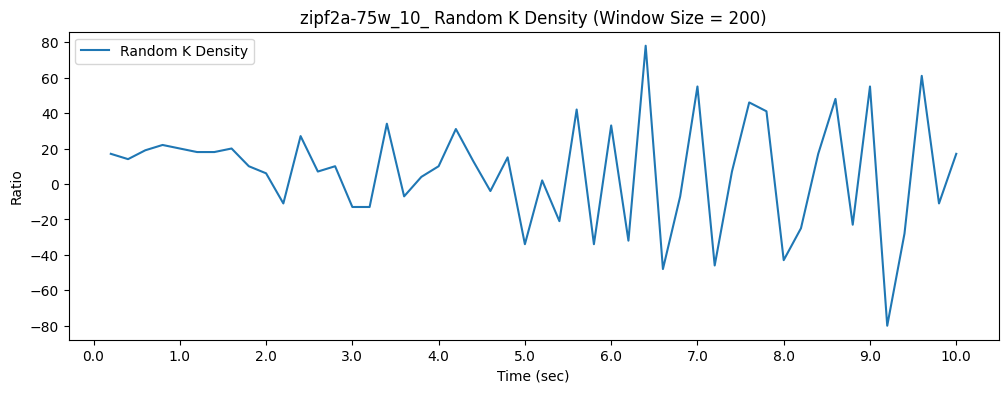

[8069, 15220, 24986, 32137, 39716, 47667, 54688, 62054, 69146, 76178, 83694, 90933, 96697, 102455, 108672, 116426, 125531, 134662, 143546, 152027, 162058, 167998, 166653, 177157, 180373, 163414, 190836, 189682, 198903, 184202, 211204, 196391, 207008, 202647, 201949, 206652, 196822, 222893, 227114, 220844, 208179, 202780, 205648, 251296, 245916, 212289, 220205, 237385, 229204, 239845]
4.82


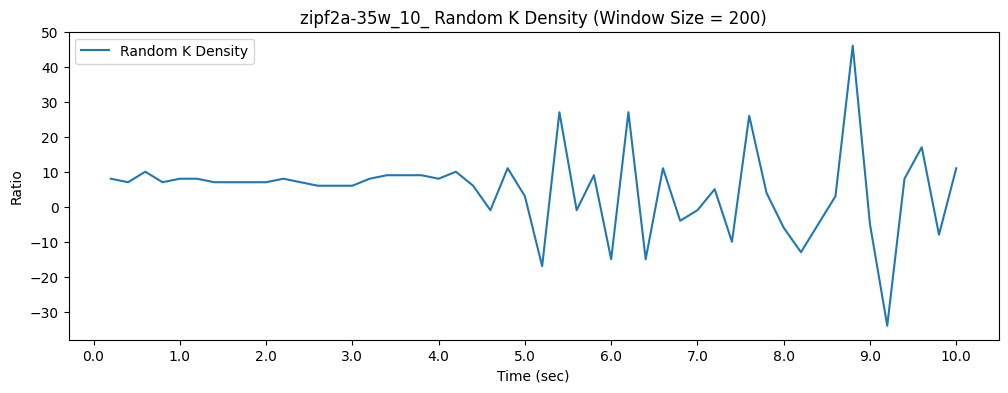

[106919, 167587, 216502, 270326, 322213, 359535, 416599, 463029, 511989, 567595, 614570, 675145, 697225, 734759, 768049, 819283, 855236, 920954, 960115, 959339, 1021578, 1054487, 1115267, 1161229, 1205497, 1258388, 1348479, 1359192, 1378672, 1486171, 1476429, 1511106, 1597473, 1608620, 1662140, 1679266, 1690054, 1758346, 1788279, 1856126, 1845732, 1916488, 2018145, 2021043, 2058106, 2067978, 2209556, 2167802, 2235184, 2234299]
44.7


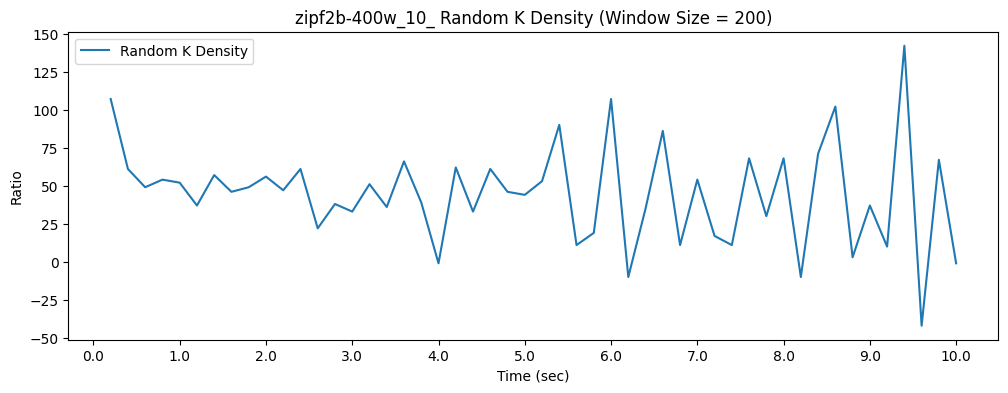

[61208, 93462, 118518, 150076, 160904, 177034, 204791, 229993, 248307, 274766, 285337, 304126, 308656, 360720, 355591, 361790, 412165, 397366, 404560, 428960, 452361, 506808, 473737, 503744, 540571, 547303, 562317, 593115, 588833, 614243, 631013, 666797, 652926, 621726, 654967, 720910, 749583, 708251, 724126, 756403, 771423, 762409, 817897, 860498, 896529, 935320, 922180, 935130, 934622, 989699]
19.78


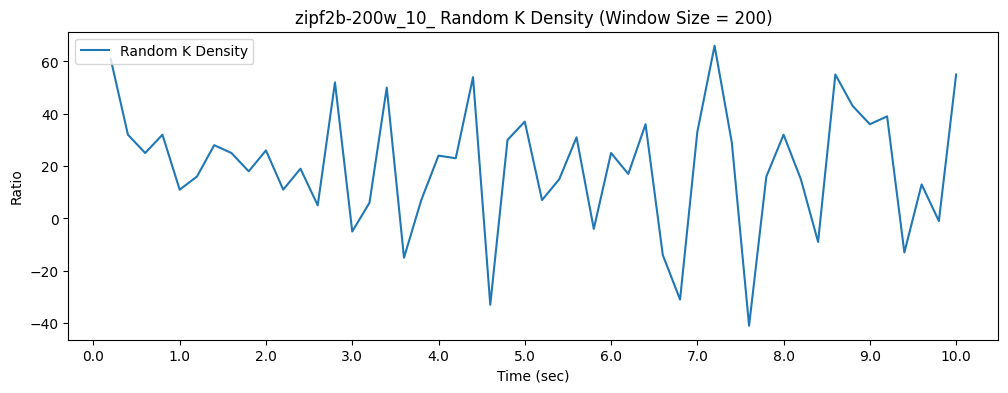

[34219, 66498, 83067, 94561, 109469, 127953, 137136, 130762, 161485, 167224, 163568, 191341, 201108, 203922, 217825, 202065, 182873, 199863, 228136, 249575, 248563, 245426, 267256, 296791, 293794, 271338, 264733, 287071, 304011, 322699, 372056, 308930, 334890, 346392, 351105, 327658, 366090, 358383, 378366, 418806, 348612, 372332, 386124, 389044, 398529, 415070, 422175, 442888, 465660, 467506]
9.38


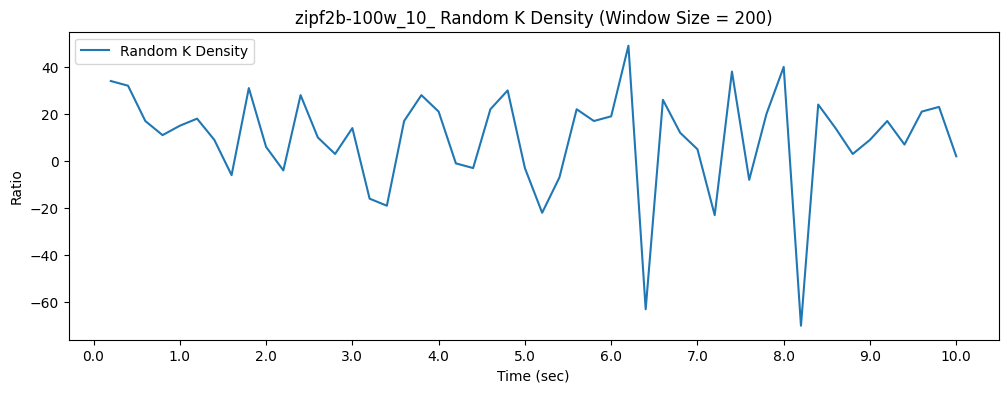

In [25]:
for file in pcap_file:
    plot_density_variation(dataset=file)

### Plot Quantized FSD

In [9]:
def prepare_profiler_bins():
    res = {}
    
    profiler_path = "../traffic_generator/fs_dist/"
    profiler_fsd = []
    for file in sorted(os.listdir(profiler_path)):
        profiler_fsd.append(file)
        
    for file in profiler_fsd:
        path = os.path.join(profiler_path, file)
        
        # Read file to get profilers' flow size distribution
        fsd = {}
        fn = 0
        with open(path, 'r') as f:
            for line in f:
                fsd[int(line.strip().split()[0])] = int(line.strip().split()[1])
                fn += int(line.strip().split()[1])
                
        # calcualte CDF
        cdf = {}
        culmulative_prob = 0.0
        for fs, freq in sorted(fsd.items()):
            culmulative_prob += (freq/fn)
            cdf[fs] = culmulative_prob
            
        # get bins
        bin = {}
        idx = 0
        for fs, prob in sorted(cdf.items()):
            while idx < round(prob * 100):
                bin[idx] = fs
                idx += 1
                
        res[file[:-4]] = bin
            
    return res
    
# prepare_profiler_bins()

In [10]:
def get_quantized_mapping(fsd, bins):
    qfsd = {}
    idx = 0
    for fs, freq in sorted(fsd.items()):
        while fs > bins[idx]:
            if idx < len(bins) - 1:
                idx += 1
            else:
                break
            
        if bins[idx] in qfsd.keys():
            qfsd[bins[idx]] += freq
        else:
            qfsd[bins[idx]] = freq
            
        
    return qfsd

In [11]:
def plot_quantized_fsd(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['10'], dataset='caida0517-500w_10_.pcap', window_size=200, profiler='caida0517-500w'):
    
    bins = prepare_profiler_bins()[profiler]
    fsd = read_fsd_data(algo, row, width, level, seed, count, flowkey, epochs, dataset, window_size)
    
    print(bins)
    # for a in fsd:
    #     print(a)
    
    qfsd = []
        
    # get profiler qfsd
    profiler_fsd_path = f'/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/{profiler}.txt'
    profiler_fsd = {}
    with open(profiler_fsd_path, 'r') as f:
        for line in f:
            profiler_fsd[int(line.strip().split()[0])] = int(line.strip().split()[1])        
    profiler_qfsd = get_quantized_mapping(profiler_fsd, bins) 
    qfsd.append(profiler_qfsd)
    
    # get each window qfsd
    for item in fsd:
        qfsd.append(get_quantized_mapping(item, bins))
        
    print(qfsd)
        
    # plot CDF
    fs = []
    prob = []
    cdfs = []
    labels = [profiler]
    
    
    for single_qfsd in qfsd:
        flow_size = []
        frequency = []
        total_packets = 0
        
        for flows, freq in single_qfsd.items():
            flow_size.append(flows)
            frequency.append(freq)
            total_packets = flows*freq
        
        # Plot PDF & CDF
        total_flows = sum(frequency)
        probabilities = [freq / total_flows for freq in frequency]
        # print(flow_size)
        # print("Total Flows: ", total_flows)
        # print("Total Packets: ", total_packets)
        # print("Density: ", int(total_packets/total_flows))
        # print(probabilities)
        
        cdf = np.cumsum(probabilities)
        
        fs.append(flow_size)
        prob.append(probabilities)
        cdfs.append(cdf)
        
    # plot every second
    for t in range(1):
        start = 1 + t*5
        end = min(len(fs), 6 + t*5)
        end = len(fs)
        
        plt.figure(figsize=(10, 5))
        plt.suptitle(f'{profiler} {start} {end}')
        # Plot PDF
        plt.subplot(1, 2, 1)
        
        plt.plot(fs[0], prob[0], linestyle='-', label = labels[0], color='black', linewidth=3.0)
        # for i in range(len(fs)):
        for i in range(start, end):
            plt.plot(fs[i], prob[i], linestyle='-')
        
        # plt.bar(flow_size, probabilities, width=1.0, color='blue', alpha=0.7)
        plt.title('Probability Density Function (PDF)')
        plt.xlabel('Flow Size')
        plt.ylabel('Probability')
        plt.legend(loc="upper right")
        
        plt.xscale('log')  # Set x-axis scale to logarithmic
        plt.xlim([-10,10000])
        plt.xticks([1, 10, 100, 1000, 10000])  # Set specific tick positions
        plt.grid(True)
        
        # Plot CDF
        plt.subplot(1, 2, 2)
        # for i in range(len(fs)):
        plt.plot(fs[0], cdfs[0], linestyle='-', label=labels[0], color='black', linewidth=3.0)
        for i in range(start, end):
            plt.plot(fs[i], cdfs[i], linestyle='-')
        plt.title('Cumulative Distribution Function (CDF)')
        plt.xlabel('Flow Size')
        plt.ylabel('Cumulative Probability')
        plt.legend(loc="lower right")
        
        plt.xscale('log')  # Set x-axis scale to logarithmic
        plt.xlim([-10,100000])
        plt.xticks([1, 10, 100, 1000, 10000])  # Set specific tick positions

        plt.grid(True)
        
        
        plt.tight_layout()
        plt.show()
    


{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 5, 60: 5, 61: 5, 62: 5, 63: 6, 64: 6, 65: 6, 66: 7, 67: 7, 68: 7, 69: 8, 70: 8, 71: 9, 72: 9, 73: 10, 74: 10, 75: 11, 76: 11, 77: 12, 78: 13, 79: 14, 80: 15, 81: 16, 82: 18, 83: 19, 84: 21, 85: 23, 86: 26, 87: 30, 88: 34, 89: 39, 90: 45, 91: 53, 92: 64, 93: 79, 94: 100, 95: 134, 96: 187, 97: 303, 98: 550, 99: 1541}
[{1: 37033, 2: 13629, 3: 7994, 4: 5113, 5: 3869, 6: 3821, 7: 2746, 8: 2234, 9: 1934, 10: 2318, 11: 1847, 12: 1578, 13: 1188, 14: 1015, 15: 900, 16: 944, 18: 1399, 19: 572, 21: 1131, 23: 868, 26: 1139, 30: 1307, 34: 1005, 39: 1022, 45: 1004, 53: 1060, 64: 1028, 79: 1087, 100:

/tmp/ipykernel_16691/1615936617.py:83: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([-10,10000])
/tmp/ipykernel_16691/1615936617.py:99: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([-10,100000])


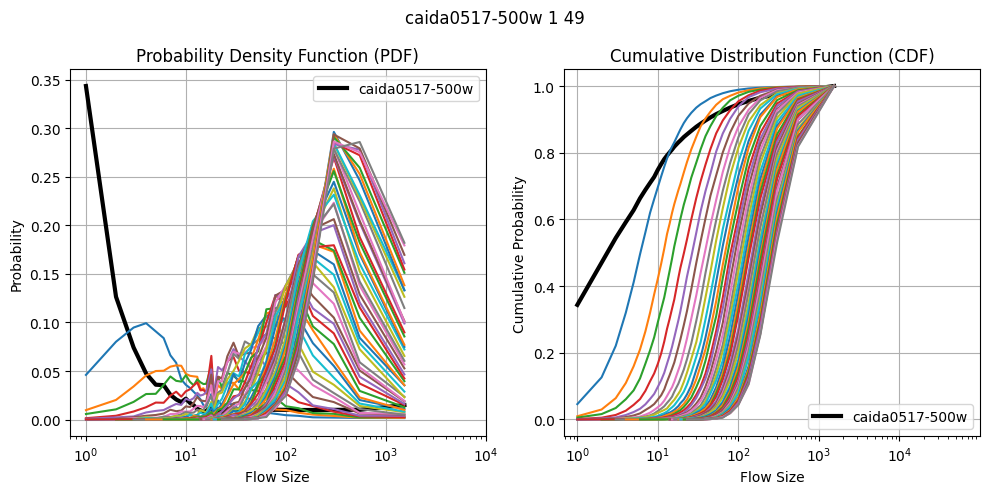

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 5, 60: 5, 61: 5, 62: 5, 63: 6, 64: 6, 65: 6, 66: 7, 67: 7, 68: 7, 69: 8, 70: 8, 71: 9, 72: 9, 73: 10, 74: 10, 75: 11, 76: 12, 77: 12, 78: 13, 79: 14, 80: 15, 81: 16, 82: 18, 83: 19, 84: 21, 85: 24, 86: 26, 87: 30, 88: 34, 89: 39, 90: 45, 91: 54, 92: 65, 93: 79, 94: 100, 95: 133, 96: 185, 97: 299, 98: 550, 99: 1494}
[{1: 18567, 2: 6745, 3: 3993, 4: 2577, 5: 1870, 6: 1885, 7: 1379, 8: 1097, 9: 957, 10: 1172, 11: 960, 12: 782, 13: 612, 14: 507, 15: 463, 16: 478, 18: 704, 19: 282, 21: 587, 24: 646, 26: 349, 30: 661, 34: 486, 39: 504, 45: 499, 54: 589, 65: 535, 79: 492, 100: 545, 133: 537, 

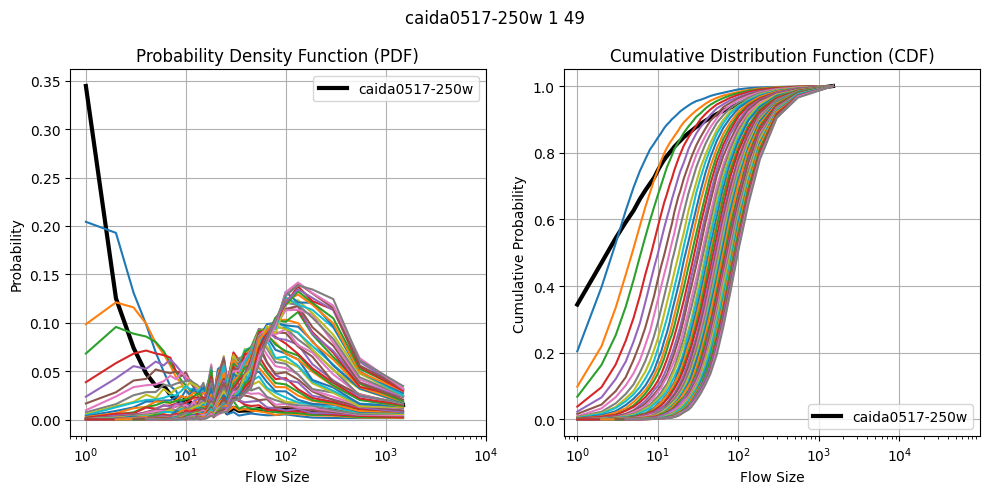

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 5, 60: 5, 61: 5, 62: 5, 63: 6, 64: 6, 65: 6, 66: 6, 67: 7, 68: 7, 69: 8, 70: 8, 71: 9, 72: 9, 73: 10, 74: 10, 75: 11, 76: 11, 77: 12, 78: 13, 79: 14, 80: 15, 81: 16, 82: 17, 83: 19, 84: 21, 85: 23, 86: 26, 87: 30, 88: 34, 89: 38, 90: 44, 91: 52, 92: 63, 93: 77, 94: 97, 95: 131, 96: 183, 97: 293, 98: 537, 99: 1608}
[{1: 9271, 2: 3371, 3: 2027, 4: 1263, 5: 995, 6: 988, 7: 682, 8: 577, 9: 463, 10: 558, 11: 476, 12: 368, 13: 295, 14: 249, 15: 230, 16: 249, 17: 165, 19: 311, 21: 274, 23: 229, 26: 286, 30: 312, 34: 258, 38: 224, 44: 266, 52: 272, 63: 265, 77: 268, 97: 271, 131: 266, 183: 267

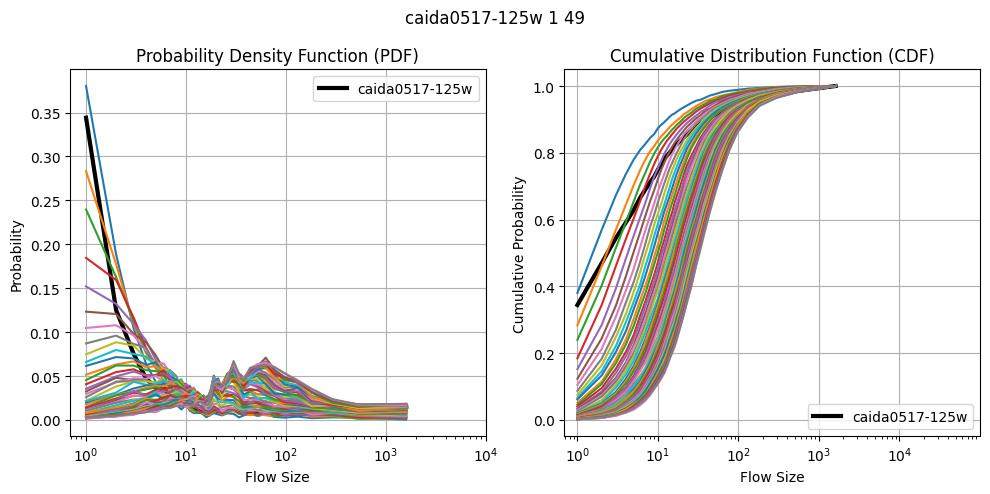

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 5, 59: 5, 60: 5, 61: 6, 62: 6, 63: 6, 64: 6, 65: 7, 66: 7, 67: 8, 68: 8, 69: 9, 70: 9, 71: 10, 72: 10, 73: 11, 74: 11, 75: 12, 76: 12, 77: 13, 78: 14, 79: 15, 80: 16, 81: 18, 82: 19, 83: 21, 84: 23, 85: 26, 86: 29, 87: 33, 88: 38, 89: 44, 90: 52, 91: 62, 92: 75, 93: 93, 94: 119, 95: 159, 96: 230, 97: 368, 98: 682, 99: 1789}
[{1: 38344, 2: 13472, 3: 7950, 4: 5630, 5: 3912, 6: 4176, 7: 2681, 8: 2285, 9: 1878, 10: 2622, 11: 1989, 12: 1894, 13: 1270, 14: 1161, 15: 1139, 16: 1202, 18: 1496, 19: 628, 21: 1315, 23: 983, 26: 1178, 29: 1011, 33: 1152, 38: 1133, 44: 1010, 52: 1161, 62: 1094, 75: 1114, 

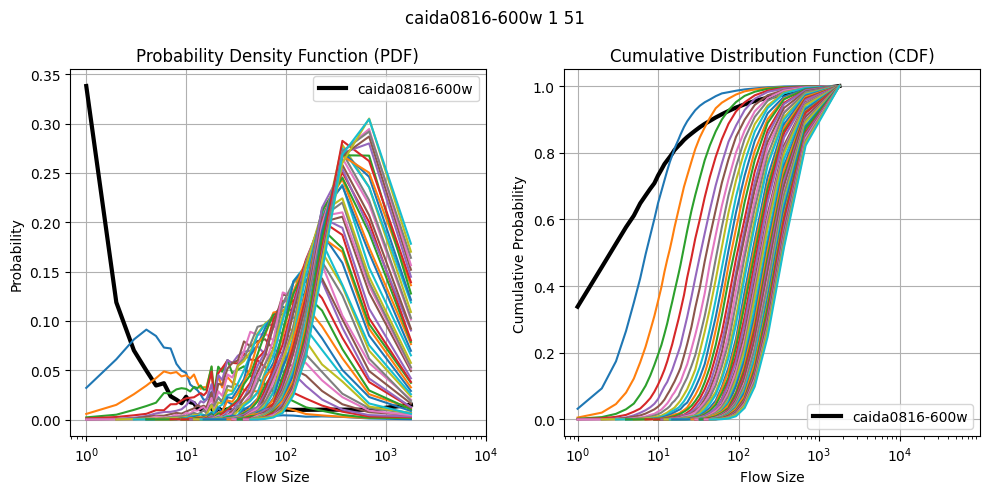

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 5, 59: 5, 60: 5, 61: 6, 62: 6, 63: 6, 64: 6, 65: 7, 66: 7, 67: 8, 68: 8, 69: 9, 70: 9, 71: 10, 72: 10, 73: 11, 74: 11, 75: 12, 76: 12, 77: 13, 78: 14, 79: 15, 80: 16, 81: 18, 82: 19, 83: 21, 84: 23, 85: 26, 86: 29, 87: 33, 88: 38, 89: 44, 90: 52, 91: 62, 92: 75, 93: 93, 94: 118, 95: 155, 96: 220, 97: 355, 98: 654, 99: 1722}
[{1: 19082, 2: 6713, 3: 3976, 4: 2904, 5: 1984, 6: 2058, 7: 1363, 8: 1147, 9: 947, 10: 1298, 11: 956, 12: 944, 13: 633, 14: 593, 15: 581, 16: 611, 18: 743, 19: 328, 21: 635, 23: 502, 26: 576, 29: 507, 33: 575, 38: 573, 44: 521, 52: 580, 62: 567, 75: 568, 93: 564, 118: 561,

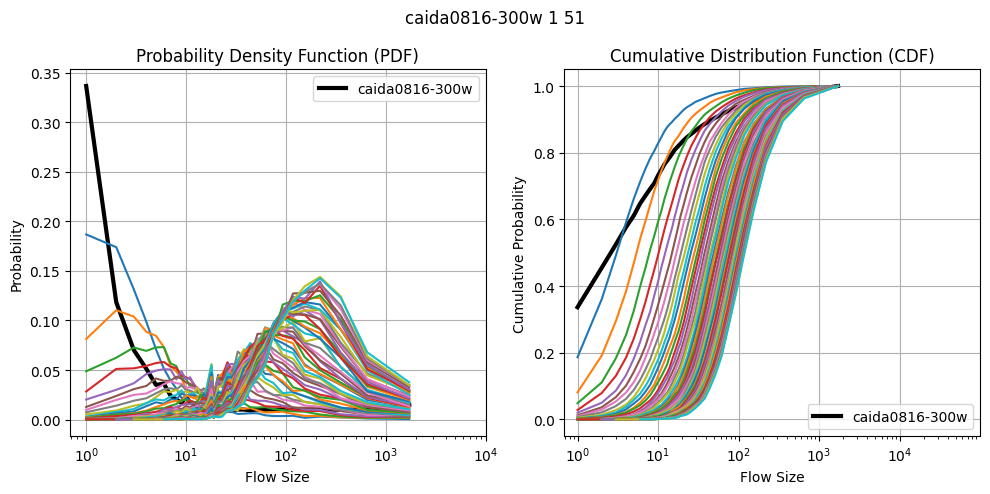

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 5, 59: 5, 60: 5, 61: 6, 62: 6, 63: 6, 64: 6, 65: 7, 66: 7, 67: 8, 68: 8, 69: 9, 70: 9, 71: 10, 72: 10, 73: 11, 74: 11, 75: 12, 76: 13, 77: 14, 78: 14, 79: 15, 80: 16, 81: 18, 82: 19, 83: 21, 84: 23, 85: 26, 86: 29, 87: 33, 88: 38, 89: 45, 90: 53, 91: 62, 92: 76, 93: 94, 94: 119, 95: 157, 96: 221, 97: 369, 98: 689, 99: 1728}
[{1: 9562, 2: 3328, 3: 1997, 4: 1484, 5: 979, 6: 1011, 7: 665, 8: 583, 9: 455, 10: 650, 11: 478, 12: 474, 13: 299, 14: 289, 15: 296, 16: 307, 18: 385, 19: 164, 21: 326, 23: 266, 26: 278, 29: 257, 33: 299, 38: 265, 45: 312, 53: 258, 62: 270, 76: 297, 94: 281, 119: 279, 157:

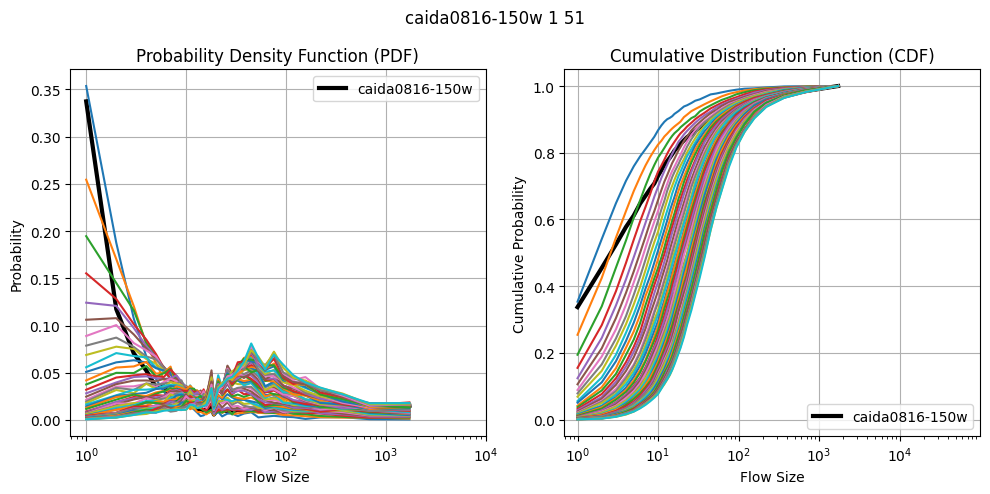

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 4, 84: 4, 85: 4, 86: 5, 87: 5, 88: 5, 89: 6, 90: 7, 91: 8, 92: 9, 93: 10, 94: 12, 95: 15, 96: 22, 97: 38, 98: 88, 99: 523}
[{1: 50438, 2: 9799, 3: 4092, 4: 2519, 5: 1847, 6: 1113, 7: 920, 8: 654, 9: 494, 10: 544, 12: 775, 15: 722, 22: 829, 38: 728, 88: 746, 523: 1158}, {1: 2028, 2: 1061, 3: 436, 4: 213, 5: 103, 6: 90, 7: 64, 8: 43, 9: 44, 10: 32, 12: 63, 15: 51, 22: 89, 38: 73, 88: 76, 523: 50}, {1: 1954, 2: 1844, 3: 112

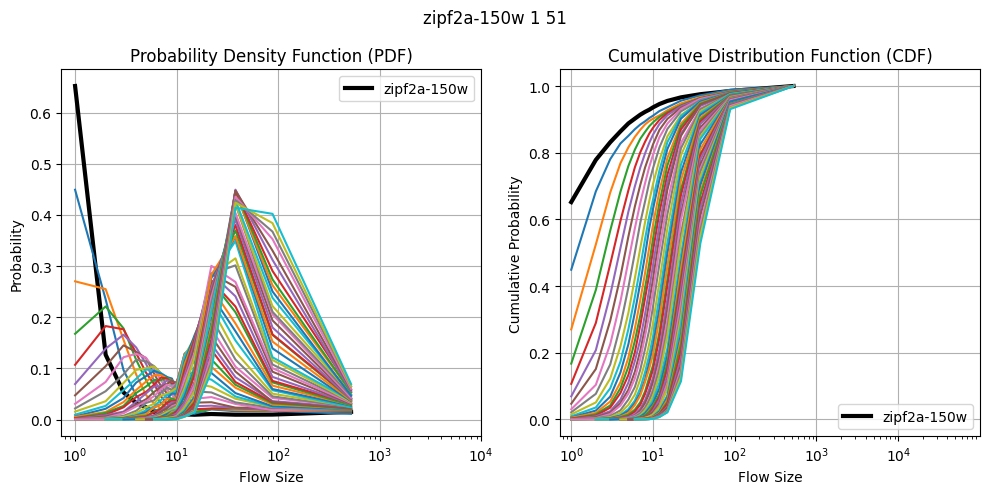

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 4, 84: 4, 85: 4, 86: 5, 87: 5, 88: 5, 89: 6, 90: 7, 91: 8, 92: 9, 93: 10, 94: 12, 95: 16, 96: 22, 97: 38, 98: 91, 99: 562}
[{1: 25130, 2: 4952, 3: 2062, 4: 1253, 5: 934, 6: 547, 7: 467, 8: 328, 9: 241, 10: 269, 12: 387, 16: 462, 22: 332, 38: 358, 91: 390, 562: 577}, {1: 1311, 2: 374, 3: 145, 4: 57, 5: 45, 6: 36, 7: 27, 8: 23, 9: 23, 10: 11, 12: 25, 16: 29, 22: 37, 38: 45, 91: 40, 562: 30}, {1: 1847, 2: 702, 3: 315, 4: 13

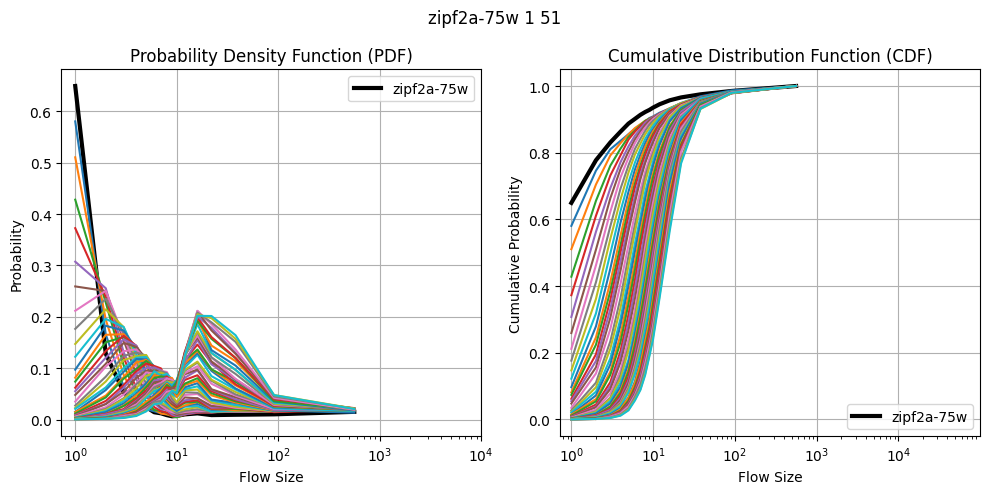

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 4, 84: 4, 85: 4, 86: 5, 87: 5, 88: 5, 89: 6, 90: 7, 91: 8, 92: 9, 93: 10, 94: 12, 95: 16, 96: 22, 97: 40, 98: 95, 99: 552}
[{1: 12632, 2: 2414, 3: 1021, 4: 639, 5: 477, 6: 266, 7: 237, 8: 178, 9: 107, 10: 136, 12: 184, 16: 223, 22: 157, 40: 198, 95: 187, 552: 288}, {1: 694, 2: 175, 3: 47, 4: 27, 5: 22, 6: 19, 7: 15, 8: 11, 9: 9, 10: 6, 12: 17, 16: 12, 22: 17, 40: 24, 95: 21, 552: 13}, {1: 1086, 2: 266, 3: 113, 4: 48, 5: 

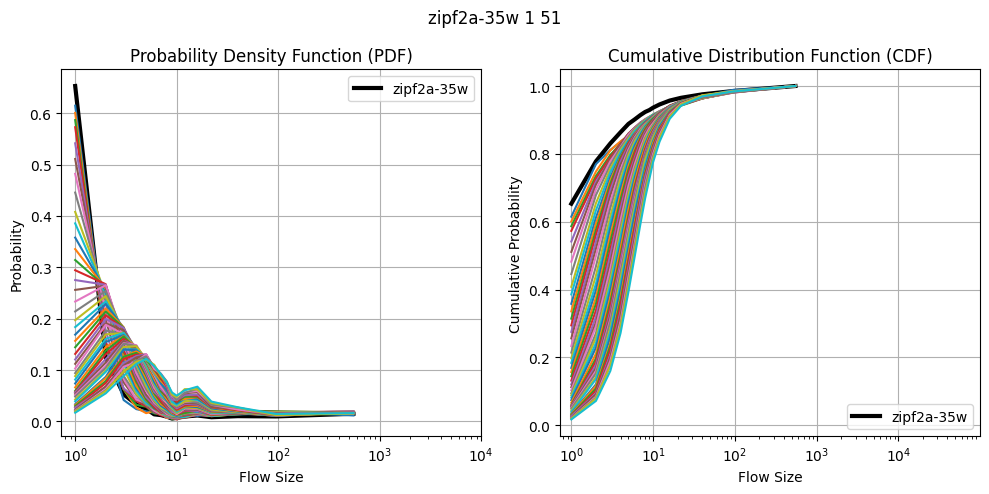

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 4, 88: 4, 89: 5, 90: 5, 91: 6, 92: 7, 93: 8, 94: 10, 95: 12, 96: 16, 97: 25, 98: 60, 99: 375}
[{1: 205974, 2: 30566, 3: 12257, 4: 7670, 5: 5388, 6: 3382, 7: 2529, 8: 1956, 10: 2945, 12: 2406, 16: 2577, 25: 2556, 60: 2814, 375: 4288}, {1: 20, 2: 132, 3: 324, 4: 752, 5: 1113, 6: 1314, 7: 1424, 8: 1138, 10: 1622, 12: 827, 16: 662, 25: 354, 60: 207, 375: 111}, {2: 7, 3: 31, 4: 75, 5: 179, 6: 310, 

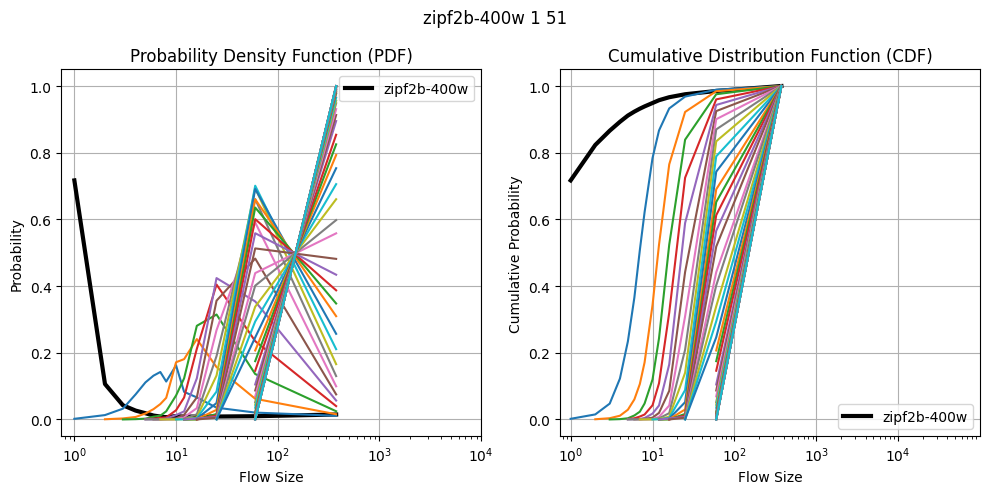

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 4, 88: 4, 89: 5, 90: 5, 91: 6, 92: 7, 93: 8, 94: 10, 95: 12, 96: 16, 97: 25, 98: 58, 99: 355}
[{1: 103014, 2: 15284, 3: 6086, 4: 3834, 5: 2722, 6: 1704, 7: 1270, 8: 941, 10: 1470, 12: 1157, 16: 1340, 25: 1299, 58: 1401, 355: 2132}, {1: 697, 2: 1881, 3: 2475, 4: 1908, 5: 1162, 6: 641, 7: 359, 8: 188, 10: 183, 12: 109, 16: 88, 25: 117, 58: 105, 355: 87}, {1: 133, 2: 557, 3: 1129, 4: 1563, 5: 164

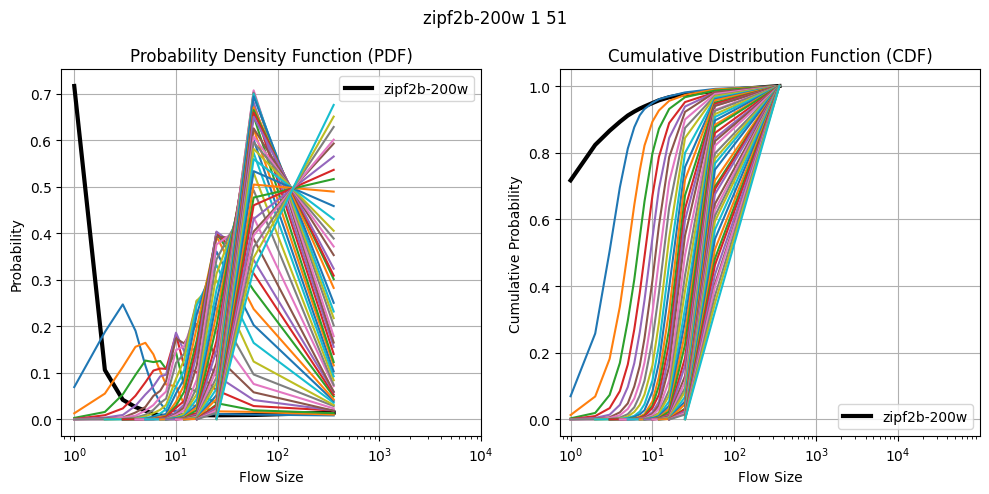

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 4, 88: 4, 89: 5, 90: 5, 91: 6, 92: 7, 93: 8, 94: 10, 95: 12, 96: 16, 97: 24, 98: 57, 99: 356}
[{1: 51542, 2: 7686, 3: 2986, 4: 1892, 5: 1366, 6: 874, 7: 627, 8: 446, 10: 752, 12: 602, 16: 686, 24: 600, 57: 699, 356: 1069}, {1: 2585, 2: 2564, 3: 1038, 4: 436, 5: 157, 6: 84, 7: 53, 8: 40, 10: 50, 12: 31, 16: 45, 24: 63, 57: 59, 356: 77}, {1: 1602, 2: 2916, 3: 2350, 4: 1283, 5: 663, 6: 343, 7: 16

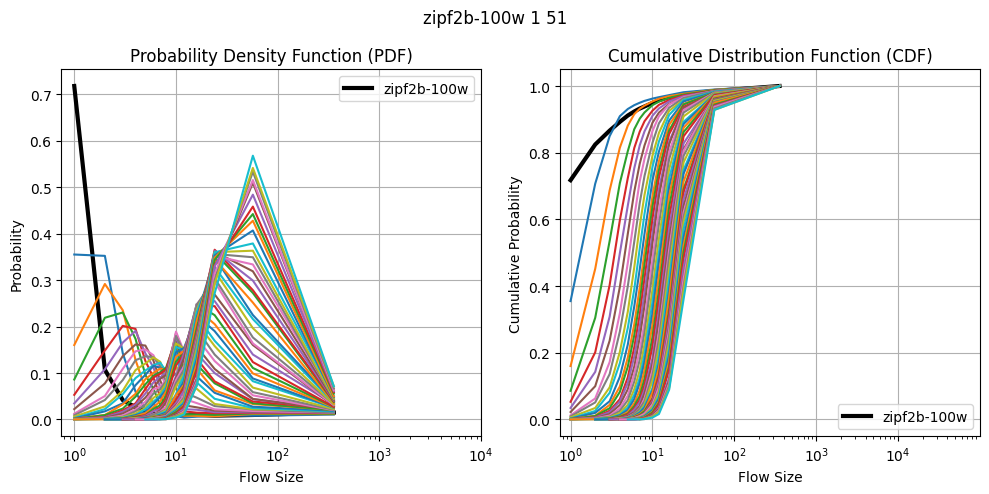

In [26]:
for file in pcap_file:
    plot_quantized_fsd(dataset=file, profiler=file[:-9])

### Plot quantized WMRD 

In [14]:
def plot_quantized_wmrd(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['10'], dataset='caida0517-500w_10_.pcap', window_size=200, profiler='caida0517-500w'):
    
    bins = prepare_profiler_bins()[profiler]
    fsd = read_fsd_data(algo, row, width, level, seed, count, flowkey, epochs, dataset, window_size)
    
    print(bins)
    # for a in fsd:
    #     print(a)
    
    qfsd = []
        
    # get profiler qfsd
    profiler_fsd_path = f'/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/{profiler}.txt'
    profiler_fsd = {}
    with open(profiler_fsd_path, 'r') as f:
        for line in f:
            profiler_fsd[int(line.strip().split()[0])] = int(line.strip().split()[1])        
    profiler_qfsd = get_quantized_mapping(profiler_fsd, bins) 
    # qfsd.append(profiler_qfsd)
    
    # get each window qfsd
    for item in fsd:
        qfsd.append(get_quantized_mapping(item, bins))
        
    print(qfsd)
        
    WMRDs = [None]
    for single_qfsd in qfsd:
        WMRD_nom = 0
        WMRD_denom = 0
        for bin in profiler_qfsd.keys():
            true = profiler_qfsd[bin]
            if bin in single_qfsd.keys():
                est = single_qfsd[bin]
            else:
                est = 0
            # print(i, true, est, est * (2**(base+1)))
            # print(bin, true, est, abs(true - est))
            WMRD_nom += abs(true - est)
            WMRD_denom += float(true + est)/2
        WMRD = WMRD_nom/WMRD_denom
        WMRDs.append(WMRD)
    print(WMRDs)
        
    plt.figure(figsize=(12, 4))
    
    plt.plot(WMRDs, label='MRD Var')

    # Add labels and legend
    plt.xlabel('Time (sec)')
    plt.ylabel('WMRD')
    plt.title('%s Random K MRD (Window Size = %d)' % (dataset[:-5], window_size))
    # plt.axhline(10000, c="black")
    ticks = [i for i in range(int(10*1000/window_size) + 1)]
    adjusted_ticks = [tick * (window_size / 1000) for tick in ticks[0::int(1000 / window_size)]]
    plt.xticks(ticks[0::int(1000/window_size)], adjusted_ticks)
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 5, 60: 5, 61: 5, 62: 5, 63: 6, 64: 6, 65: 6, 66: 7, 67: 7, 68: 7, 69: 8, 70: 8, 71: 9, 72: 9, 73: 10, 74: 10, 75: 11, 76: 11, 77: 12, 78: 13, 79: 14, 80: 15, 81: 16, 82: 18, 83: 19, 84: 21, 85: 23, 86: 26, 87: 30, 88: 34, 89: 39, 90: 45, 91: 53, 92: 64, 93: 79, 94: 100, 95: 134, 96: 187, 97: 303, 98: 550, 99: 1541}
[{1: 47, 2: 83, 3: 102, 4: 93, 5: 96, 6: 94, 7: 69, 8: 62, 9: 42, 10: 27, 11: 31, 12: 24, 13: 21, 14: 14, 15: 16, 16: 14, 18: 35, 19: 12, 21: 16, 23: 7, 26: 21, 30: 16, 34: 10, 39: 11, 45: 9, 53: 9, 64: 4, 79: 7, 100: 2, 134: 2, 187: 1, 303: 3}, {1: 18, 2: 20, 3: 30, 4: 43, 

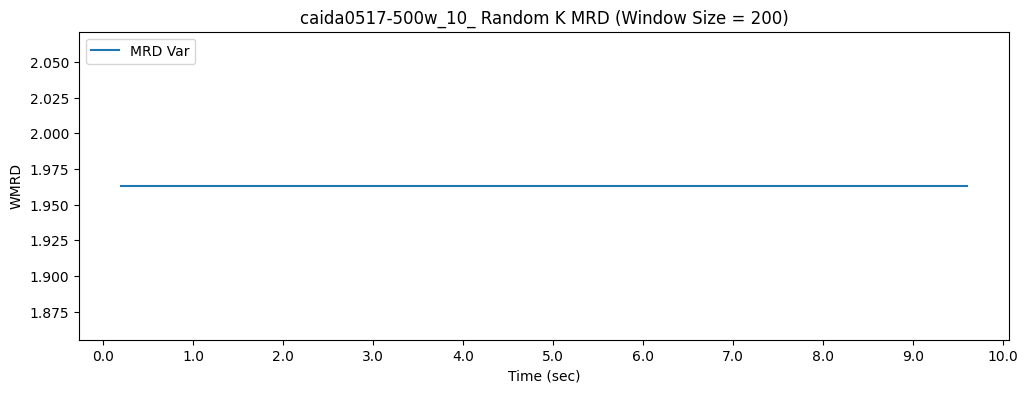

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 5, 60: 5, 61: 5, 62: 5, 63: 6, 64: 6, 65: 6, 66: 7, 67: 7, 68: 7, 69: 8, 70: 8, 71: 9, 72: 9, 73: 10, 74: 10, 75: 11, 76: 12, 77: 12, 78: 13, 79: 14, 80: 15, 81: 16, 82: 18, 83: 19, 84: 21, 85: 24, 86: 26, 87: 30, 88: 34, 89: 39, 90: 45, 91: 54, 92: 65, 93: 79, 94: 100, 95: 133, 96: 185, 97: 299, 98: 550, 99: 1494}
[{1: 205, 2: 180, 3: 150, 4: 96, 5: 67, 6: 48, 7: 35, 8: 29, 9: 15, 10: 14, 11: 9, 12: 16, 13: 16, 14: 6, 15: 9, 16: 7, 18: 12, 19: 5, 21: 7, 24: 15, 26: 4, 30: 9, 34: 2, 39: 7, 45: 7, 54: 6, 65: 2, 79: 8, 100: 4, 133: 3, 185: 1, 299: 2, 550: 1, 1494: 3}, {1: 114, 2: 123, 3:

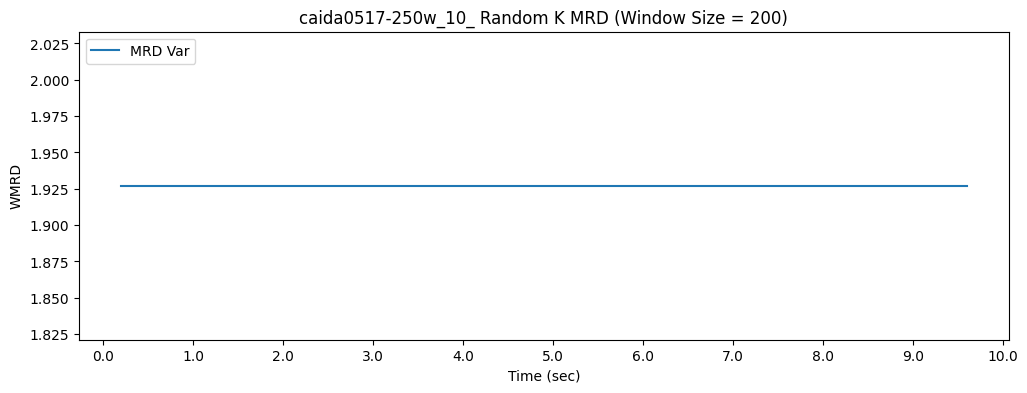

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 2, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 4, 55: 4, 56: 4, 57: 4, 58: 4, 59: 5, 60: 5, 61: 5, 62: 5, 63: 6, 64: 6, 65: 6, 66: 6, 67: 7, 68: 7, 69: 8, 70: 8, 71: 9, 72: 9, 73: 10, 74: 10, 75: 11, 76: 11, 77: 12, 78: 13, 79: 14, 80: 15, 81: 16, 82: 17, 83: 19, 84: 21, 85: 23, 86: 26, 87: 30, 88: 34, 89: 38, 90: 44, 91: 52, 92: 63, 93: 77, 94: 97, 95: 131, 96: 183, 97: 293, 98: 537, 99: 1608}
[{1: 382, 2: 195, 3: 94, 4: 59, 5: 47, 6: 28, 7: 23, 8: 17, 9: 9, 10: 21, 11: 11, 12: 4, 13: 3, 14: 10, 15: 7, 16: 3, 17: 4, 19: 10, 21: 6, 23: 5, 26: 8, 30: 7, 34: 3, 38: 6, 44: 9, 52: 2, 63: 8, 77: 2, 97: 2, 131: 5, 183: 5, 293: 1, 537: 3, 1608: 1}, {1: 281, 2: 193, 3: 108,

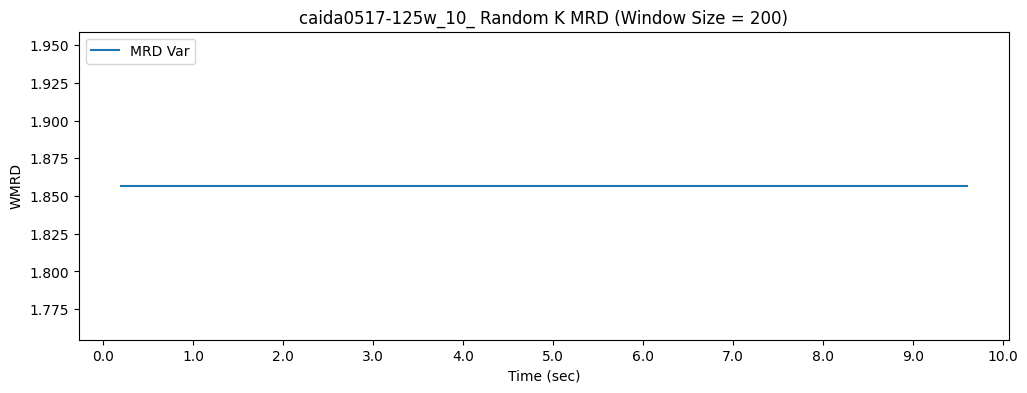

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 5, 59: 5, 60: 5, 61: 6, 62: 6, 63: 6, 64: 6, 65: 7, 66: 7, 67: 8, 68: 8, 69: 9, 70: 9, 71: 10, 72: 10, 73: 11, 74: 11, 75: 12, 76: 12, 77: 13, 78: 14, 79: 15, 80: 16, 81: 18, 82: 19, 83: 21, 84: 23, 85: 26, 86: 29, 87: 33, 88: 38, 89: 44, 90: 52, 91: 62, 92: 75, 93: 93, 94: 119, 95: 159, 96: 230, 97: 368, 98: 682, 99: 1789}
[{1: 25, 2: 61, 3: 92, 4: 102, 5: 84, 6: 70, 7: 67, 8: 54, 9: 51, 10: 45, 11: 26, 12: 34, 13: 22, 14: 29, 15: 19, 16: 13, 18: 32, 19: 10, 21: 30, 23: 18, 26: 17, 29: 25, 33: 18, 38: 8, 44: 14, 52: 9, 62: 9, 75: 3, 93: 4, 119: 2, 159: 3, 230: 3, 368: 1}, {1: 9, 2: 18, 3: 24

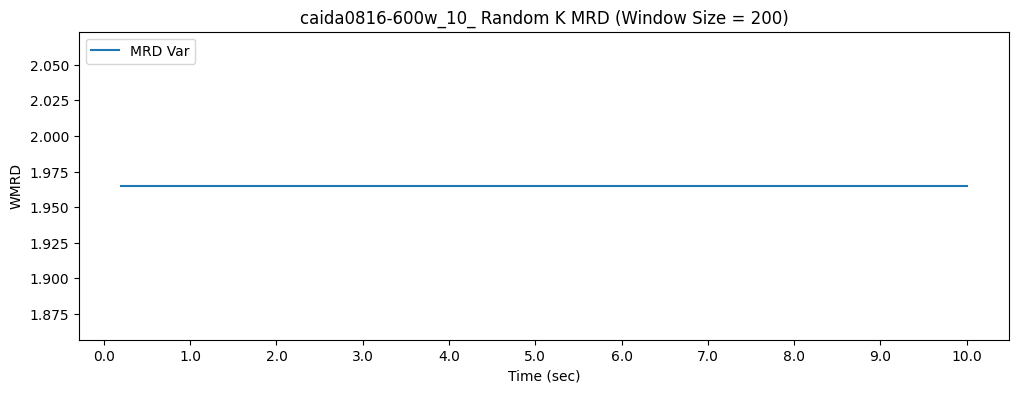

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 2, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 5, 59: 5, 60: 5, 61: 6, 62: 6, 63: 6, 64: 6, 65: 7, 66: 7, 67: 8, 68: 8, 69: 9, 70: 9, 71: 10, 72: 10, 73: 11, 74: 11, 75: 12, 76: 12, 77: 13, 78: 14, 79: 15, 80: 16, 81: 18, 82: 19, 83: 21, 84: 23, 85: 26, 86: 29, 87: 33, 88: 38, 89: 44, 90: 52, 91: 62, 92: 75, 93: 93, 94: 118, 95: 155, 96: 220, 97: 355, 98: 654, 99: 1722}
[{1: 191, 2: 160, 3: 137, 4: 94, 5: 68, 6: 54, 7: 36, 8: 26, 9: 29, 10: 24, 11: 16, 12: 16, 13: 12, 14: 6, 15: 7, 16: 5, 18: 13, 19: 6, 21: 16, 23: 12, 26: 5, 29: 6, 33: 7, 38: 8, 44: 5, 52: 5, 62: 10, 75: 7, 93: 4, 118: 6, 155: 2, 220: 4, 355: 2, 654: 1}, {1: 88, 2: 116, 

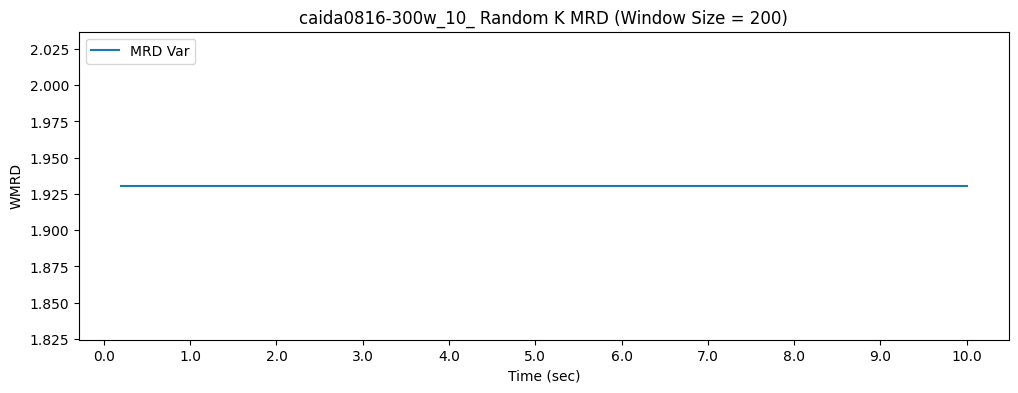

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 2, 35: 2, 36: 2, 37: 2, 38: 2, 39: 2, 40: 2, 41: 2, 42: 2, 43: 2, 44: 2, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 4, 54: 4, 55: 4, 56: 4, 57: 4, 58: 5, 59: 5, 60: 5, 61: 6, 62: 6, 63: 6, 64: 6, 65: 7, 66: 7, 67: 8, 68: 8, 69: 9, 70: 9, 71: 10, 72: 10, 73: 11, 74: 11, 75: 12, 76: 13, 77: 14, 78: 14, 79: 15, 80: 16, 81: 18, 82: 19, 83: 21, 84: 23, 85: 26, 86: 29, 87: 33, 88: 38, 89: 45, 90: 53, 91: 62, 92: 76, 93: 94, 94: 119, 95: 157, 96: 221, 97: 369, 98: 689, 99: 1728}
[{1: 339, 2: 193, 3: 101, 4: 68, 5: 53, 6: 35, 7: 17, 8: 18, 9: 19, 10: 19, 11: 18, 12: 13, 13: 6, 14: 4, 15: 3, 16: 9, 18: 11, 19: 4, 21: 7, 23: 7, 26: 8, 29: 10, 33: 2, 38: 8, 45: 6, 62: 3, 76: 6, 94: 4, 119: 3, 157: 1, 221: 1, 369: 3, 689: 1}, {1: 232, 2: 192, 3: 114, 4

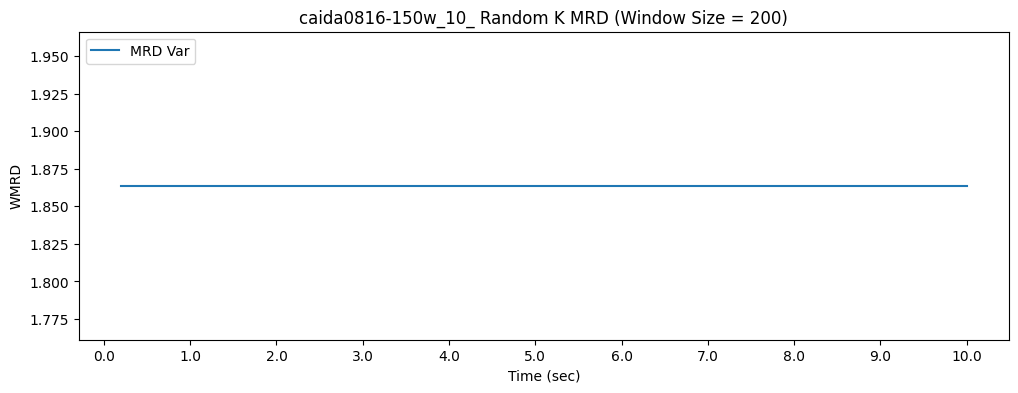

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 4, 84: 4, 85: 4, 86: 5, 87: 5, 88: 5, 89: 6, 90: 7, 91: 8, 92: 9, 93: 10, 94: 12, 95: 15, 96: 22, 97: 38, 98: 88, 99: 523}
[{1: 435, 2: 247, 3: 92, 4: 59, 5: 13, 6: 22, 7: 17, 8: 7, 9: 8, 10: 8, 12: 9, 15: 9, 22: 26, 38: 18, 88: 21, 523: 9}, {1: 274, 2: 262, 3: 143, 4: 100, 5: 51, 6: 29, 7: 21, 8: 18, 9: 10, 10: 5, 12: 7, 15: 13, 22: 23, 38: 15, 88: 17, 523: 12}, {1: 170, 2: 218, 3: 197, 4: 110, 5: 80, 6: 53, 7: 37, 8: 1

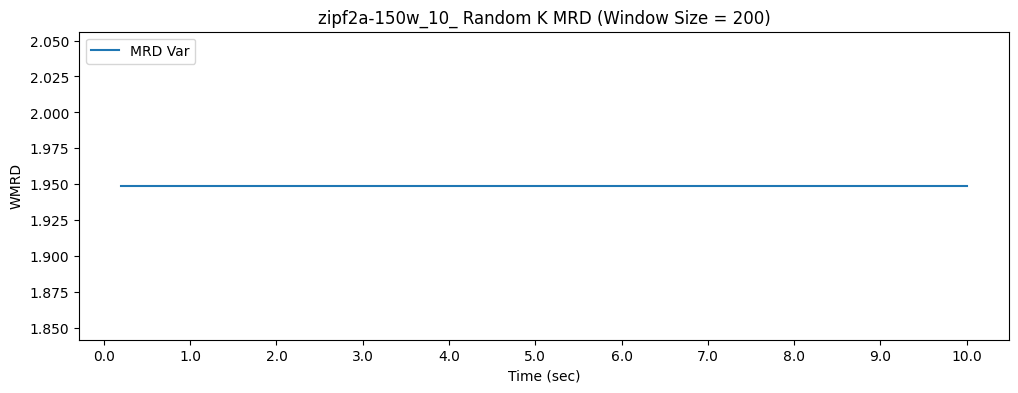

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 4, 84: 4, 85: 4, 86: 5, 87: 5, 88: 5, 89: 6, 90: 7, 91: 8, 92: 9, 93: 10, 94: 12, 95: 16, 96: 22, 97: 38, 98: 91, 99: 562}
[{1: 585, 2: 156, 3: 64, 4: 23, 5: 25, 6: 21, 7: 13, 8: 13, 9: 14, 10: 8, 12: 10, 16: 11, 22: 15, 38: 22, 91: 9, 562: 11}, {1: 514, 2: 188, 3: 81, 4: 47, 5: 28, 6: 16, 7: 14, 8: 10, 9: 5, 10: 4, 12: 8, 16: 15, 22: 15, 38: 19, 91: 23, 562: 13}, {1: 435, 2: 234, 3: 111, 4: 47, 5: 31, 6: 13, 7: 15, 8: 1

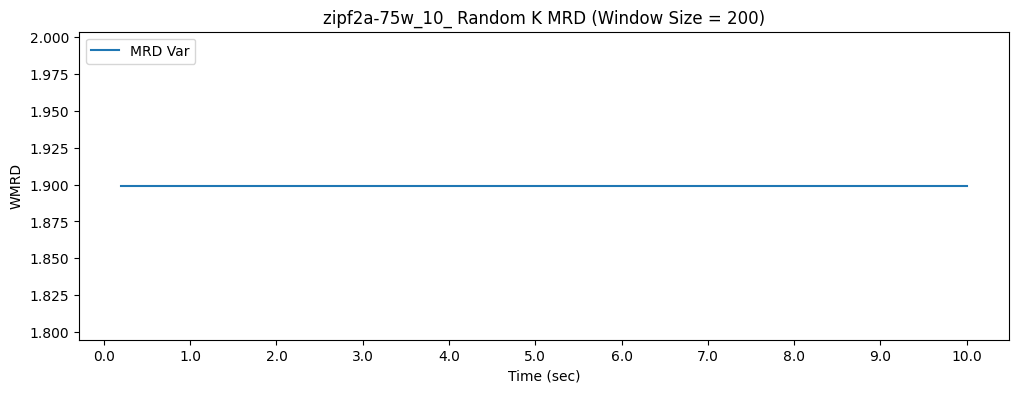

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 2, 66: 2, 67: 2, 68: 2, 69: 2, 70: 2, 71: 2, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 4, 84: 4, 85: 4, 86: 5, 87: 5, 88: 5, 89: 6, 90: 7, 91: 8, 92: 9, 93: 10, 94: 12, 95: 16, 96: 22, 97: 40, 98: 95, 99: 552}
[{1: 613, 2: 157, 3: 44, 4: 26, 5: 18, 6: 19, 7: 11, 8: 10, 9: 7, 10: 5, 12: 15, 16: 10, 22: 16, 40: 21, 95: 19, 552: 9}, {1: 605, 2: 146, 3: 66, 4: 26, 5: 18, 6: 23, 7: 10, 8: 6, 9: 9, 10: 6, 12: 4, 16: 14, 22: 19, 40: 17, 95: 16, 552: 15}, {1: 594, 2: 142, 3: 61, 4: 39, 5: 26, 6: 10, 7: 13, 8: 11, 

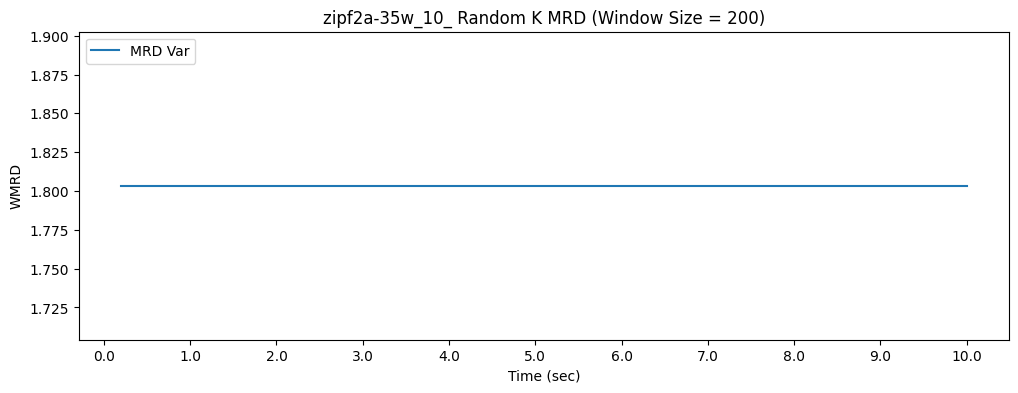

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 4, 88: 4, 89: 5, 90: 5, 91: 6, 92: 7, 93: 8, 94: 10, 95: 12, 96: 16, 97: 25, 98: 60, 99: 375}
[{2: 6, 3: 34, 4: 68, 5: 122, 6: 111, 7: 148, 8: 129, 10: 179, 12: 82, 16: 65, 25: 32, 60: 18, 375: 6}, {3: 3, 4: 8, 5: 12, 6: 24, 7: 48, 8: 65, 10: 170, 12: 171, 16: 258, 25: 158, 60: 71, 375: 12}, {3: 1, 4: 4, 5: 4, 6: 15, 7: 11, 8: 16, 10: 85, 12: 124, 16: 269, 25: 308, 60: 140, 375: 23}, {5: 1, 6:

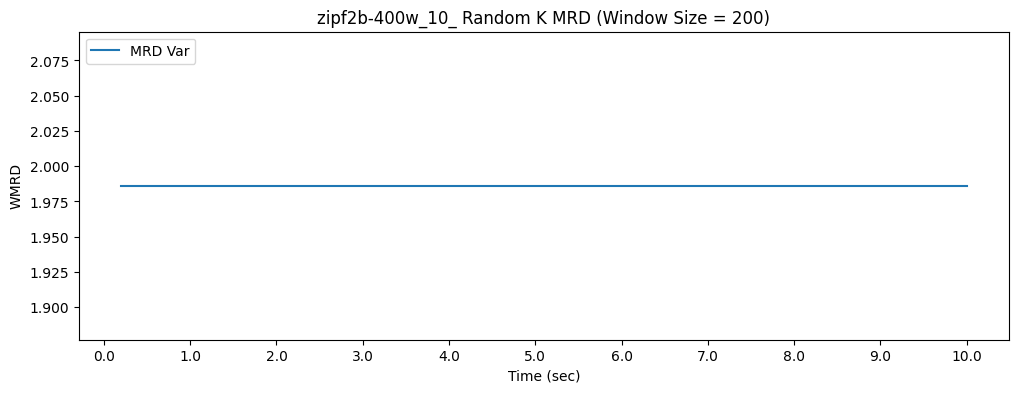

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 4, 88: 4, 89: 5, 90: 5, 91: 6, 92: 7, 93: 8, 94: 10, 95: 12, 96: 16, 97: 25, 98: 58, 99: 355}
[{1: 67, 2: 203, 3: 246, 4: 195, 5: 107, 6: 69, 7: 40, 8: 14, 10: 7, 12: 12, 16: 13, 25: 14, 58: 9, 355: 4}, {1: 12, 2: 55, 3: 123, 4: 159, 5: 156, 6: 134, 7: 123, 8: 82, 10: 65, 12: 29, 16: 26, 25: 10, 58: 14, 355: 12}, {1: 5, 2: 20, 3: 42, 4: 86, 5: 126, 6: 136, 7: 126, 8: 110, 10: 141, 12: 72, 16: 

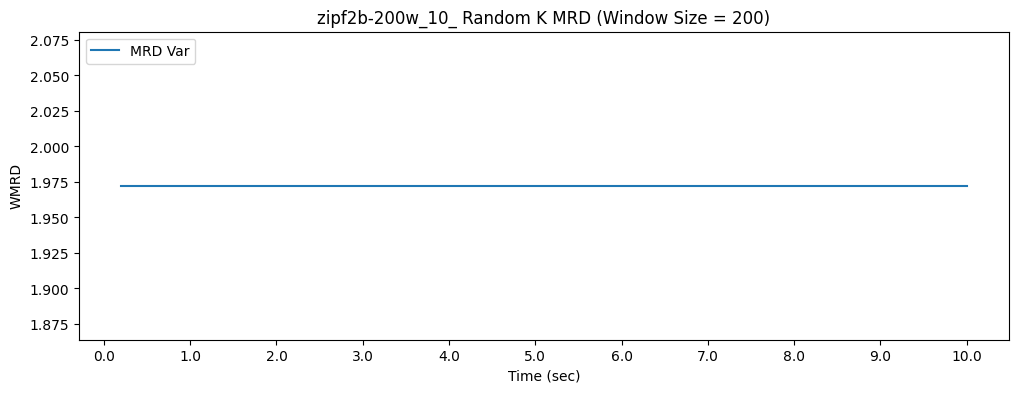

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 2, 73: 2, 74: 2, 75: 2, 76: 2, 77: 2, 78: 2, 79: 2, 80: 2, 81: 2, 82: 3, 83: 3, 84: 3, 85: 3, 86: 3, 87: 4, 88: 4, 89: 5, 90: 5, 91: 6, 92: 7, 93: 8, 94: 10, 95: 12, 96: 16, 97: 24, 98: 57, 99: 356}
[{1: 374, 2: 356, 3: 143, 4: 49, 5: 15, 6: 15, 7: 7, 8: 7, 10: 5, 12: 1, 16: 5, 24: 8, 57: 6, 356: 9}, {1: 152, 2: 295, 3: 239, 4: 123, 5: 70, 6: 40, 7: 10, 8: 10, 10: 20, 12: 3, 16: 7, 24: 5, 57: 14, 356: 12}, {1: 92, 2: 190, 3: 225, 4: 182, 5: 105, 6: 63, 7: 40, 8: 22, 10: 14, 12: 13, 16: 12, 24: 7,

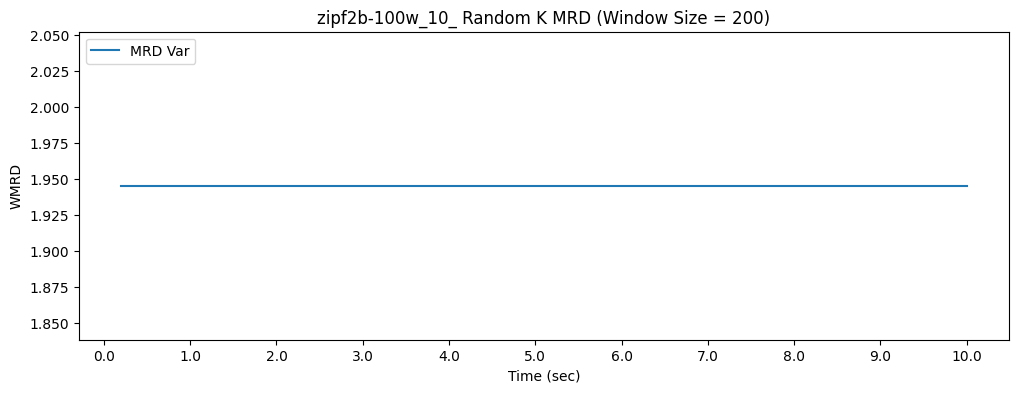

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 2, 97: 2, 98: 2, 99: 11}
[{1: 4, 2: 26, 11: 970}, {2: 2, 11: 998}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {11: 1000}, {1

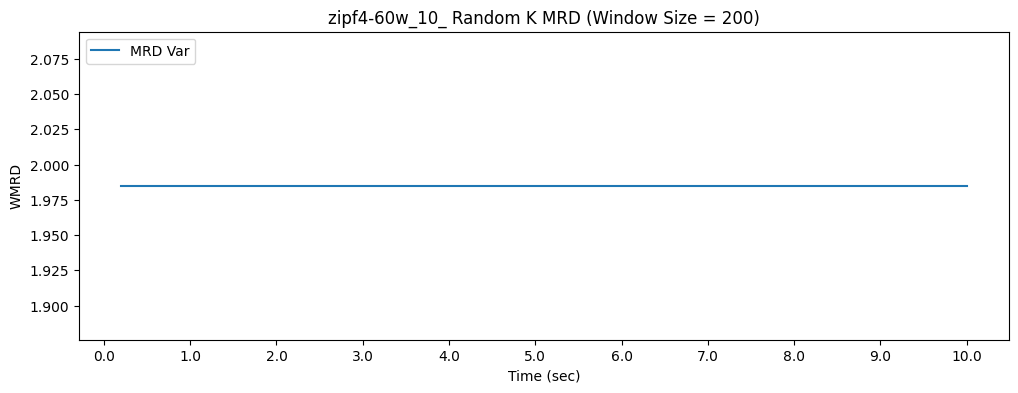

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 2, 97: 2, 98: 2, 99: 12}
[{1: 100, 2: 334, 12: 566}, {1: 21, 2: 100, 12: 879}, {1: 10, 2: 41, 12: 949}, {1: 2, 2: 27, 12: 971}, {1: 1, 2: 10, 12: 989}, {1: 2, 2: 6, 12: 992}, {2: 2, 12: 998}, {2: 1, 12: 999}, {2: 2, 12: 998}, {12: 1000}, {12: 1000}, {12: 1000}, {12: 1000}, {12: 1000}, {12: 1000}, {12: 1000}, {12: 1000}, {12: 1000},

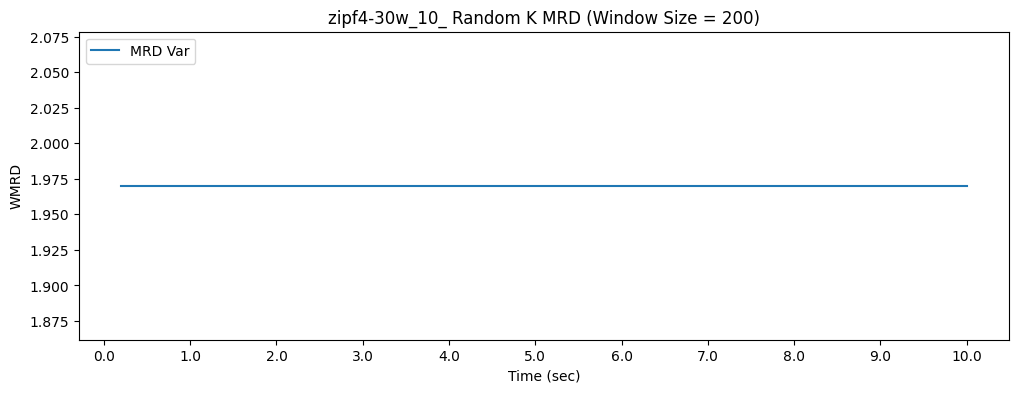

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 2, 97: 2, 98: 2, 99: 12}
[{1: 486, 2: 390, 12: 124}, {1: 255, 2: 402, 12: 343}, {1: 144, 2: 329, 12: 527}, {1: 90, 2: 282, 12: 628}, {1: 66, 2: 225, 12: 709}, {1: 36, 2: 161, 12: 803}, {1: 28, 2: 108, 12: 864}, {1: 16, 2: 80, 12: 904}, {1: 13, 2: 70, 12: 917}, {1: 9, 2: 48, 12: 943}, {1: 2, 2: 45, 12: 953}, {1: 2, 2: 20, 12: 978}, 

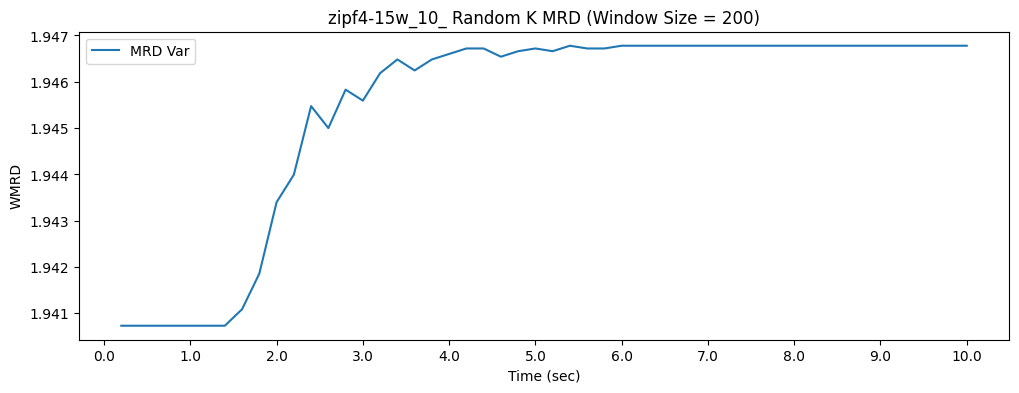

In [ ]:
for file in pcap_file:
    plot_quantized_wmrd(dataset=file, profiler=file[:-9])

### Plot MRD

In [ ]:
def plot_mrd(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['10'], dataset='caida0517-500w_10_.pcap', window_size=200, profilers=['caida0517-500w']):
    
    res = []
    label = []
    
    for profiler in profilers:
    
        bins = prepare_profiler_bins()[profiler]
        fsd = read_fsd_data(algo, row, width, level, seed, count, flowkey, epochs, dataset, window_size)
        
        # print(bins)
            
        # get profiler qfsd
        profiler_fsd_path = f'/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/{profiler}.txt'
        profiler_fsd = {}
        with open(profiler_fsd_path, 'r') as f:
            for line in f:
                profiler_fsd[int(line.strip().split()[0])] = int(line.strip().split()[1])        

        WMRDs = [None]
        for single_fsd in fsd:
            WMRD_nom = 0
            WMRD_denom = 0
            for bin in profiler_fsd.keys():
                true = profiler_fsd[bin]
                if bin in single_fsd.keys():
                    est = single_fsd[bin]
                else:
                    est = 0
                # print(i, true, est, est * (2**(base+1)))
                WMRD_nom += abs(true - est)
                WMRD_denom += float(true + est)/2
            WMRD = WMRD_nom/WMRD_denom
            WMRDs.append(WMRD)
        # print(WMRDs)
        
        res.append(WMRDs)
        label.append(profiler)
        
    plt.figure(figsize=(12, 4))
    
    plt.plot(res[0], label=label[0], color='tab:red', linewidth=3.0)
    for i in range(1, len(res)):
        plt.plot(res[i], label=label[i])

    # Add labels and legend
    plt.xlabel('Time (sec)')
    plt.ylabel('MRD')
    plt.title('%s Random K MRD (Window Size = %d)' % (dataset[:-9], window_size))
    # plt.axhline(10000, c="black")
    ticks = [i for i in range(int(10*1000/window_size) + 1)]
    adjusted_ticks = [tick * (window_size / 1000) for tick in ticks[0::int(1000 / window_size)]]
    plt.xticks(ticks[0::int(1000/window_size)], adjusted_ticks)
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

In [ ]:
profilers = []
for item in pcap_file:
    profilers.append(item[:-9])
    
# # CAIDA0517 <-> CAIDA0816
# for i in range(0,3):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[3:6])
    
# for i in range(3,6):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[0:3])


# # ZIPF2a <-> ZIPF2b
# for i in range(6,9):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[9:12])
    
# for i in range(9,12):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[6:9])


# # CAIDA -> ZIPF2a
# for i in range(0,3):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[6:9])
    
# for i in range(3,6):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[6:9])


# # CAIDA -> ZIPF2b
# for i in range(0,3):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[9:12])
    
# for i in range(3,6):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[9:12])
    
    
# # ZIPF2a -> CAIDA
# for i in range(6,9):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[0:3])
    
# for i in range(6,9):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[3:6])
    
    
# ZIPF2b -> CAIDA
# for i in range(9,12):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[0:3])
    
# for i in range(9,12):
#     plot_mrd(dataset=pcap_file[i], profilers=[profilers[i]] + profilers[3:6])
    



---

In [22]:
def plot_mrd2(algo='cm', row=3, width=4096, level=1, seed=1, count=1, flowkey='srcIP', 
              epochs=['10'], datasets=['caida0517-500w_10_.pcap'], window_size=200, profiler='caida0517-500w'):
    
    res = []
    label = []
    
    for d in datasets:
    
        bins = prepare_profiler_bins()[profiler]
        fsd = read_fsd_data(algo, row, width, level, seed, count, flowkey, epochs, d, window_size)
        
        # print(bins)
            
        # get profiler qfsd
        profiler_fsd_path = f'/home/ming/SketchMercator/pattern_detection/traffic_generator/fs_dist/{profiler}.txt'
        profiler_fsd = {}
        with open(profiler_fsd_path, 'r') as f:
            for line in f:
                profiler_fsd[int(line.strip().split()[0])] = int(line.strip().split()[1])        

        WMRDs = [None]
        for single_fsd in fsd:
            WMRD_nom = 0
            WMRD_denom = 0
            for bin in profiler_fsd.keys():
                true = profiler_fsd[bin]
                if bin in single_fsd.keys():
                    est = single_fsd[bin]
                else:
                    est = 0
                # print(i, true, est, est * (2**(base+1)))
                WMRD_nom += abs(true - est)
                WMRD_denom += float(true + est)/2
            WMRD = WMRD_nom/WMRD_denom
            WMRDs.append(WMRD)
        # print(WMRDs)
        
        res.append(WMRDs)
        label.append(d[:-5])
        
    plt.figure(figsize=(12, 4))
    
    plt.plot(res[0], label=label[0], color='tab:red', linewidth=3.0)
    for i in range(1, len(res)):
        plt.plot(res[i], label=label[i])

    # Add labels and legend
    plt.xlabel('Time (sec)')
    plt.ylabel('MRD')
    plt.title('Profiler = %s ,Random K MRD' % (profiler))
    # plt.axhline(10000, c="black")
    ticks = [i for i in range(int(10*1000/window_size) + 1)]
    adjusted_ticks = [tick * (window_size / 1000) for tick in ticks[0::int(1000 / window_size)]]
    plt.xticks(ticks[0::int(1000/window_size)], adjusted_ticks)
    plt.legend(loc='upper left')

    # Show the plot
    plt.show()

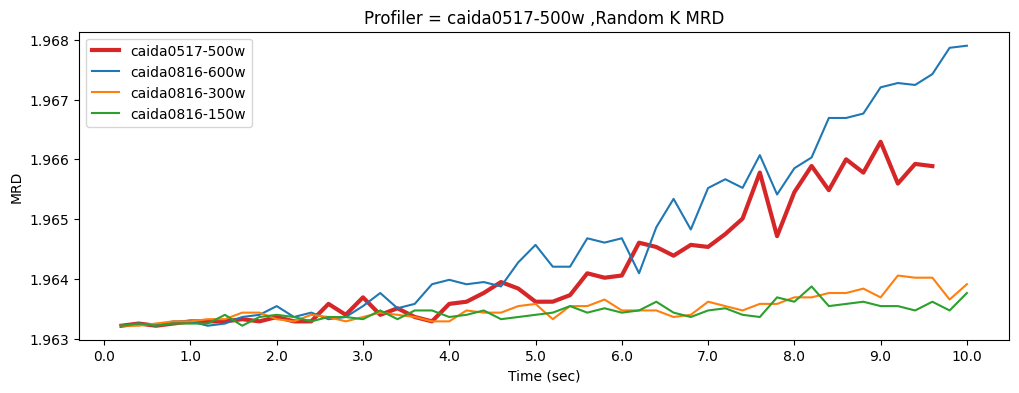

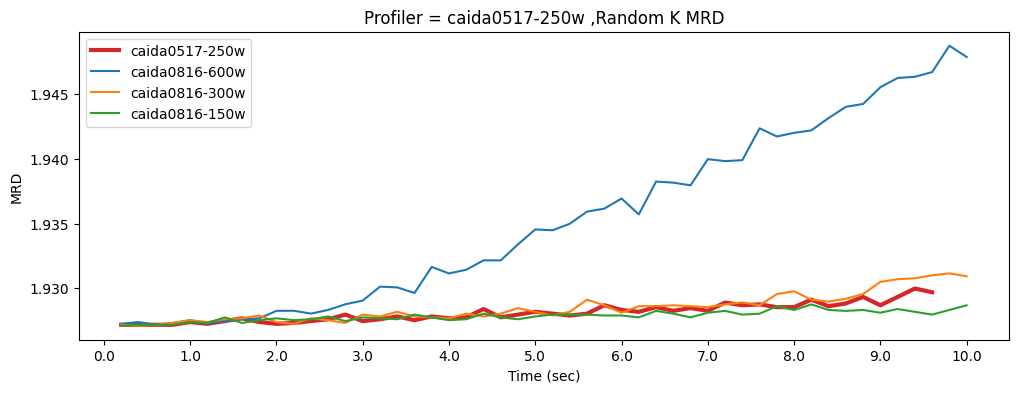

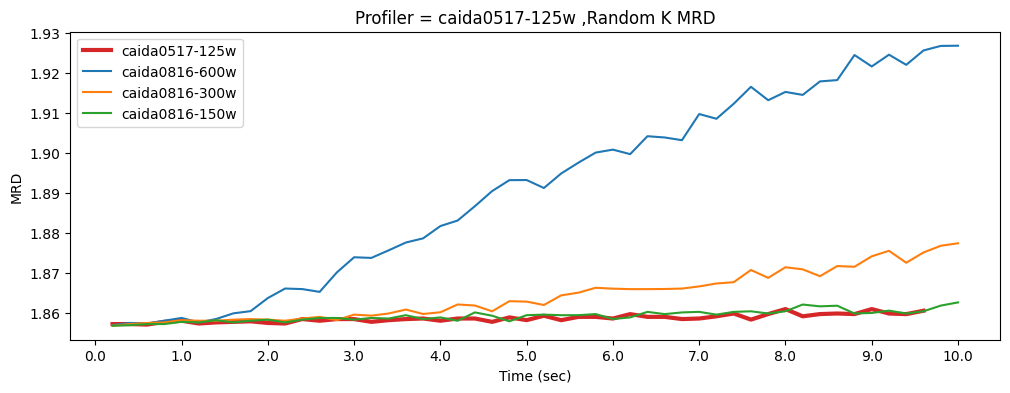

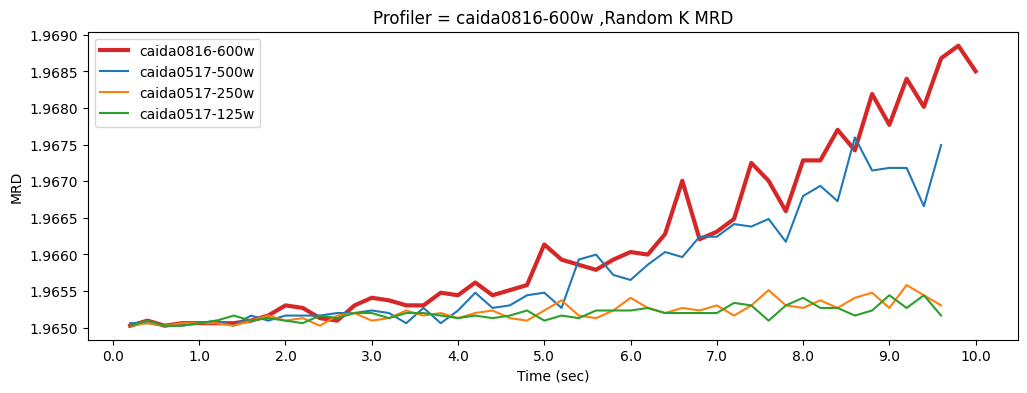

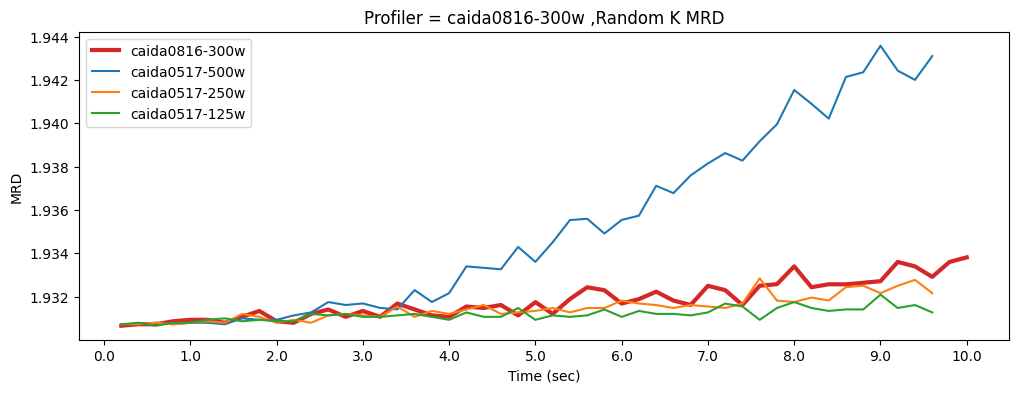

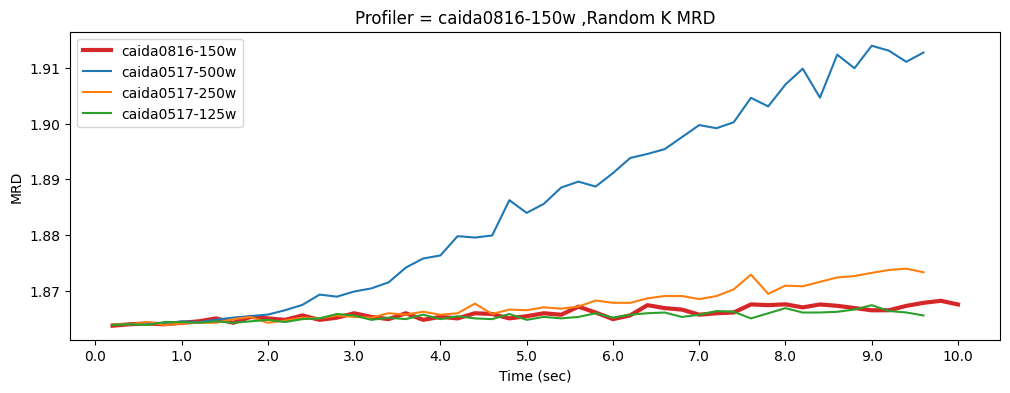

In [ ]:
profilers = []
for item in pcap_file:
    profilers.append(item[:-9])
    
# # # CAIDA0517 <-> CAIDA0816
# for i in range(0,3):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[3:6], profiler=profilers[i])
    
# for i in range(3,6):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[0:3], profiler=profilers[i])


# # ZIPF2a <-> ZIPF2b
# for i in range(6,9):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[9:12], profiler=profilers[i])
    
# for i in range(9,12):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[6:9], profiler=profilers[i])


# # CAIDA -> ZIPF2a
# for i in range(0,3):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[6:9], profiler=profilers[i])
    
# for i in range(3,6):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[6:9], profiler=profilers[i])


# # CAIDA -> ZIPF2b
# for i in range(0,3):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[9:12], profiler=profilers[i])
    
# for i in range(3,6):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[9:12], profiler=profilers[i])
    
    
# # ZIPF2a -> CAIDA
# for i in range(6,9):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[0:3], profiler=profilers[i])
    
# for i in range(6,9):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[3:6], profiler=profilers[i])
    
    
# ZIPF2b -> CAIDA
# for i in range(9,12):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[0:3], profiler=profilers[i])
    
# for i in range(9,12):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[3:6], profiler=profilers[i])
    



['caida0517-500w', 'caida0517-250w', 'caida0517-125w', 'caida0816-600w', 'caida0816-300w', 'caida0816-150w', 'zipf2a-150w', 'zipf2a-75w', 'zipf2a-35w', 'zipf2b-400w', 'zipf2b-200w', 'zipf2b-100w']


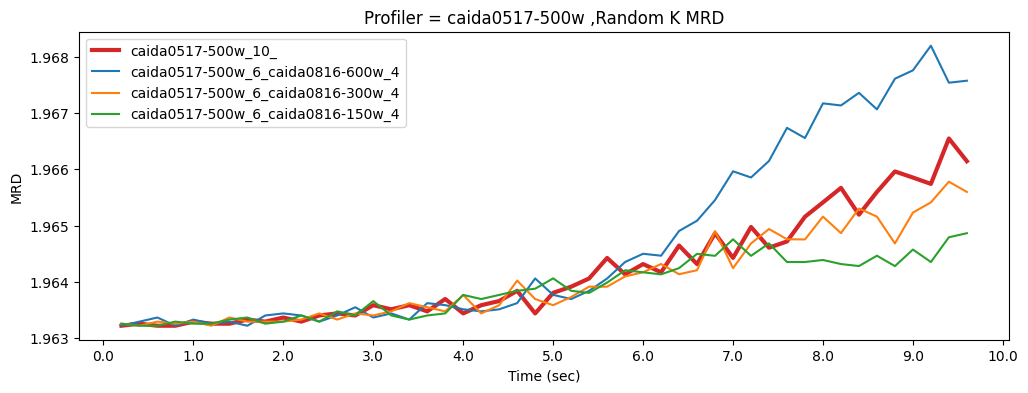

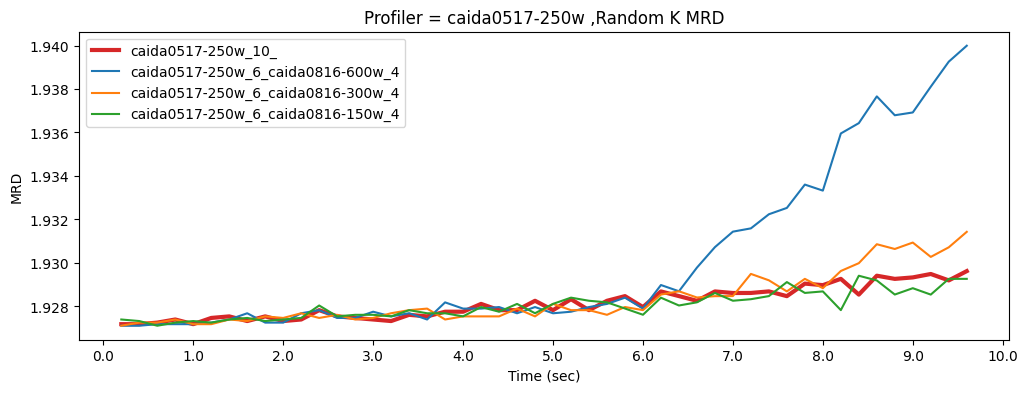

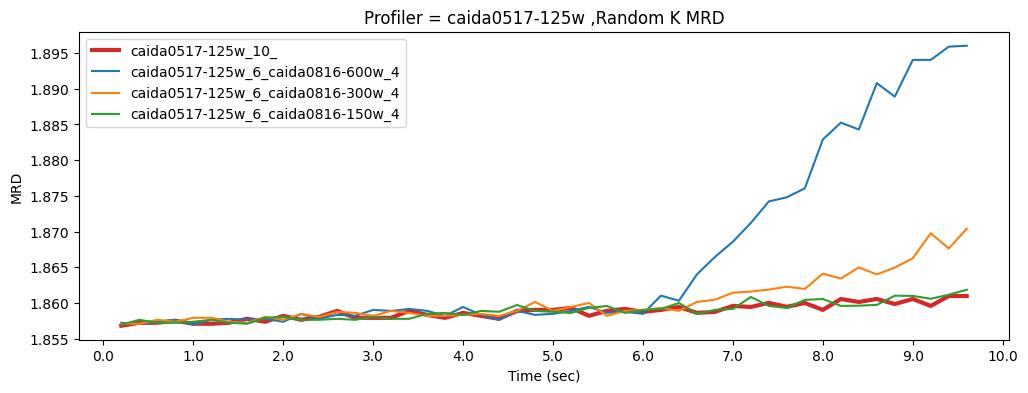

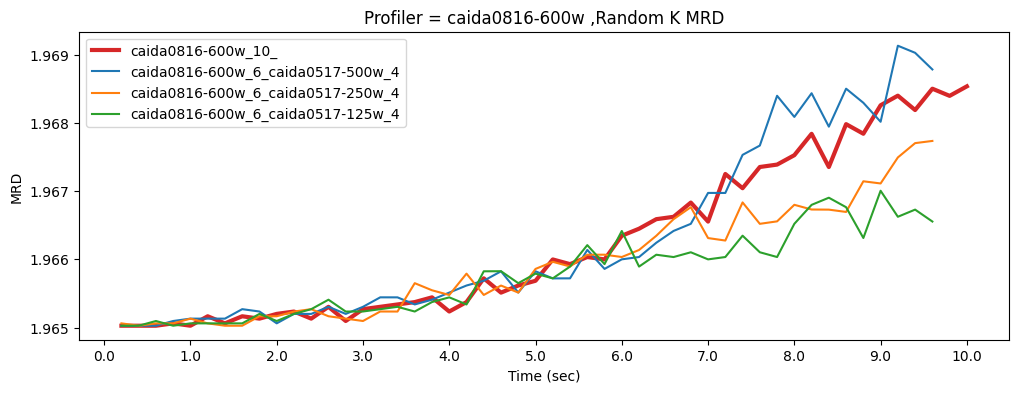

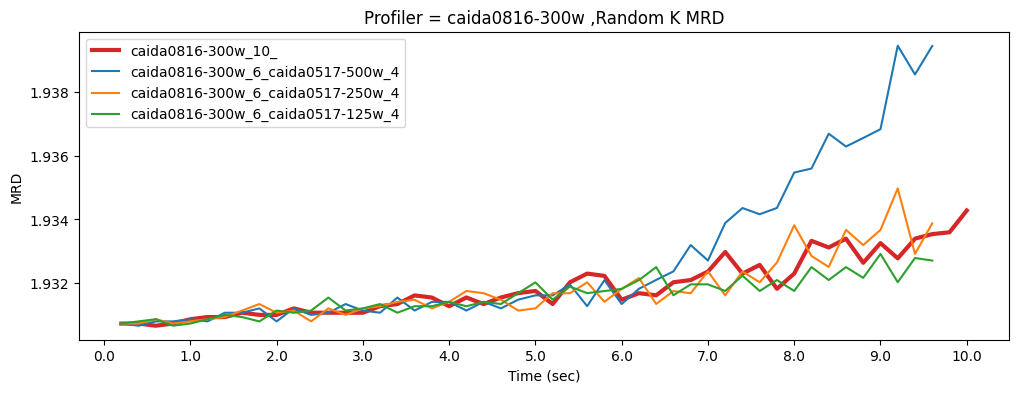

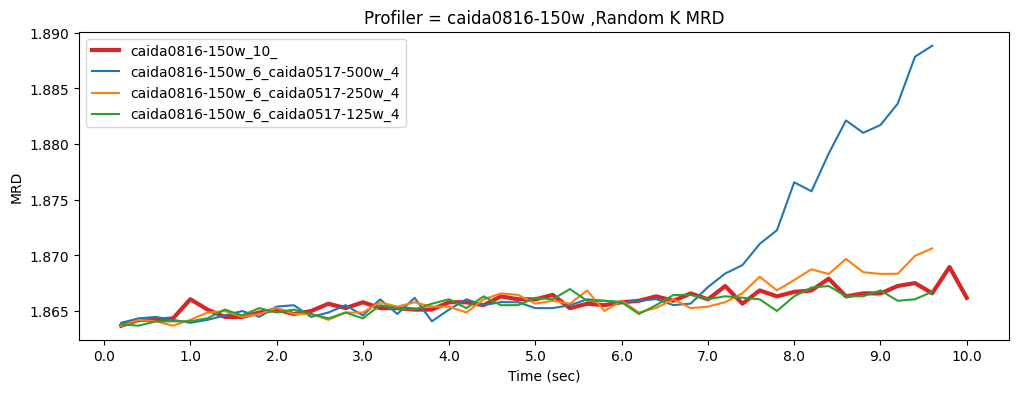

In [23]:
profilers = []
for item in pcap_file[:12]:
    profilers.append(item[:-9])
    
print(profilers)
    
# CAIDA0517 <-> CAIDA0816
for i in range(0, len(pcap_file[12:]), 3):
    # plot_mrd2(datasets=[pcap_file[9+int(i/3)]] + pcap_file[12+i:15+i], profiler=profilers[9+int(i/3)]) 
    plot_mrd2(datasets=[pcap_file[int(i/3)]] + pcap_file[12+i:15+i], profiler=profilers[int(i/3)]) 
    
# # # CAIDA0517 <-> CAIDA0816
# for i in range(0,3):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[3:6], profiler=profilers[i])
    
# for i in range(3,6):
#     plot_mrd2(datasets=[pcap_file[i]] + pcap_file[0:3], profiler=profilers[i])